In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip install sentence_transformers
!pip install pyarrow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#data_path = "/content/drive/MyDrive/data/cs7641/train_tokenized.csv"
#X_embeddings_path = "/content/drive/MyDrive/data/cs7641/X_embeddings.pq"

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/cs7641/"

### Generating Embedding

In [ ]:
from sentence_transformers import SentenceTransformer, util


In [ ]:
data = pd.read_csv(data_path+"train_tokenized.csv") # Palash's file
#data = pd.read_csv("train_tokenized.csv") # Palash's file
data.drop(columns=["Unnamed: 0"], inplace=True)
data["full_text"] = data["full_text"].apply(lambda x: x.strip())
tasks = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]
data["holistic_score"] = data[tasks].mean(axis=1)


In [ ]:
# Load the model
smodel = SentenceTransformer('multi-qa-distilbert-cos-v1')
X_embeddings = smodel.encode(data["full_text"].values, show_progress_bar=True)
X_embeddings_df = pd.concat([data[["text_id","cohesion", "syntax", "vocabulary",
                                   "phraseology", "grammar", "conventions","holistic_score"]], pd.DataFrame(X_embeddings)], axis=1)

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.46k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/123 [00:00<?, ?it/s]

In [ ]:
X_embeddings_df.head()

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions,holistic_score,0,1,...,758,759,760,761,762,763,764,765,766,767
0,0016926B079C,3.5,3.5,3.0,3.0,4.0,3.0,3.333333,-0.028515,-0.005348,...,-0.051942,-0.013297,0.036630,0.052612,-0.063326,-0.045883,-0.012272,0.045127,0.010842,-0.002583
1,0022683E9EA5,2.5,2.5,3.0,2.0,2.0,2.5,2.416667,-0.055925,0.052633,...,0.020248,-0.034654,0.018206,-0.058521,-0.038227,0.000646,0.025687,-0.040552,-0.045236,-0.047975
2,00299B378633,3.0,3.5,3.0,3.0,3.0,2.5,3.000000,-0.014516,0.009253,...,-0.012550,0.013358,0.022884,0.054505,-0.039526,-0.060184,-0.088875,0.060787,0.024077,0.013593
3,003885A45F42,4.5,4.5,4.5,4.5,4.0,5.0,4.500000,-0.011866,0.047098,...,0.024532,-0.020830,-0.007370,0.006887,-0.023901,0.003636,0.009842,0.021319,0.037490,-0.056621
4,0049B1DF5CCC,2.5,3.0,3.0,3.0,2.5,2.5,2.750000,-0.057808,-0.004076,...,0.014377,-0.077904,0.015067,0.009745,0.034251,0.008058,-0.020336,-0.004507,-0.013612,-0.013753


In [ ]:
X_embeddings_path = "/content/drive/MyDrive/cs7641/"

In [ ]:
X_embeddings_df.to_csv(X_embeddings_path+'qa_embeddings.csv')

### Using Embedding in NN Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import StratifiedKFold, train_test_split
import matplotlib.pyplot as plt

In [ ]:
data_path = "/content/drive/MyDrive/cs7641/"
X_embeddings_path = "/content/drive/MyDrive/cs7641/"

In [ ]:
embeddings = pd.read_csv(X_embeddings_path+'qa_embeddings.csv')
embeddings.shape
tasks = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]
y = embeddings[tasks]
X = embeddings.drop(columns=["Unnamed: 0","text_id","holistic_score"]+tasks)
print("y shape:", y.shape)
print("X shape:", X.shape)
X.head(5)

y shape: (3911, 6)
X shape: (3911, 768)


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.028515,-0.005348,0.018811,0.023975,0.017949,-0.011794,0.083481,0.045905,-0.023104,-0.045022,...,-0.051942,-0.013297,0.036630,0.052612,-0.063326,-0.045883,-0.012272,0.045127,0.010842,-0.002583
1,-0.055925,0.052633,-0.026289,-0.021095,0.056862,0.047442,0.028884,0.001938,0.031125,-0.092621,...,0.020248,-0.034654,0.018206,-0.058521,-0.038227,0.000646,0.025687,-0.040552,-0.045236,-0.047975
2,-0.014516,0.009253,0.018071,0.045256,-0.034040,-0.059255,0.024184,0.031153,0.005821,-0.049888,...,-0.012550,0.013358,0.022884,0.054505,-0.039526,-0.060184,-0.088875,0.060787,0.024077,0.013593
3,-0.011866,0.047098,0.048439,-0.029580,0.044906,-0.002232,0.028632,-0.029029,0.025303,-0.059538,...,0.024532,-0.020830,-0.007370,0.006887,-0.023901,0.003636,0.009842,0.021319,0.037490,-0.056621
4,-0.057808,-0.004076,0.028241,-0.061182,0.013336,0.060628,-0.000847,0.018569,0.007332,-0.087083,...,0.014377,-0.077904,0.015067,0.009745,0.034251,0.008058,-0.020336,-0.004507,-0.013612,-0.013753


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)
#converting to arrays
X_train, X_val, y_train, y_val = X_train.values, X_val.values, y_train.values, y_val.values
X,y = X.values, y.values

(3519, 768)
(392, 768)
(3519, 6)
(392, 6)


In [ ]:
#convert from numpy arrays to torch tensors
trX = torch.from_numpy(X_train).float()
teX = torch.from_numpy(X_val).float()
trY = torch.from_numpy(y_train).float()
teY = torch.from_numpy(y_val).float()
X_full = torch.from_numpy(X).float()
y_full = torch.from_numpy(y).float()
print(trX.shape)
print(teX.shape)
print(trY.shape)
print(teY.shape)
print(X_full.shape)
print(y_full.shape)

torch.Size([3519, 768])
torch.Size([392, 768])
torch.Size([3519, 6])
torch.Size([392, 6])
torch.Size([3911, 768])
torch.Size([3911, 6])


In [ ]:
#Defining Evaluation Metric
from sklearn.metrics import mean_squared_error, make_scorer
def mcrmse(y_trues, y_preds):
    scores = []
    n_tasks = y_trues.shape[1]
    for i in range(n_tasks):
        y_true = y_trues[:,i]
        y_pred = y_preds[:,i]
        score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores

def mcrmse_error(y_trues, y_preds, **kwargs):
    mcrmse_score, _ = mcrmse(y_trues, y_preds)
    return mcrmse_score


mcrmse_scorer = make_scorer(mcrmse_error, greater_is_better=False)

In [ ]:
#training function
def train(model, criterion,optimizer,x, y):
    x = Variable(x, requires_grad=False)
    y = Variable(y, requires_grad=False)
    
    # Reset gradient
    optimizer.zero_grad()

    # Forward
    fx = model.forward(x)
    loss = criterion(fx, y)
    
    # Backward
    loss.backward()

    # Update parameters
    optimizer.step()

    return loss.data

#make predictions

def predict(model, x, y):
    x = Variable(x, requires_grad=False)
    outputs = model(x)
    return outputs    

#### 1 Hidden Layer NN

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        
        #self.logsoftmax = nn.LogSoftmax()
        
    def forward(self, x):
        x = F.relu(self.i2h(x))
        x = self.h2o(x)
        return x

Initiating the network for learning rate: 1e-06
Train MCRMSE Info for Epochs = 100 is: (3.0410404, [3.10033, 2.994411, 3.145519, 3.1235433, 2.895564, 2.986875])
Train MCRMSE Info for Epochs = 200 is: (2.907272, [2.9638407, 2.8584654, 3.0038927, 2.98806, 2.7712648, 2.8581083])
Train MCRMSE Info for Epochs = 300 is: (2.7619019, [2.81508, 2.711203, 2.8507767, 2.840915, 2.6354935, 2.7179422])
Train MCRMSE Info for Epochs = 400 is: (2.595434, [2.6452806, 2.5423598, 2.675611, 2.6723878, 2.4800017, 2.5569632])
Train MCRMSE Info for Epochs = 500 is: (2.3983188, [2.4440055, 2.3434334, 2.4683282, 2.4724393, 2.295523, 2.3661835])
Train MCRMSE Info for Epochs = 600 is: (2.1628478, [2.203423, 2.1076357, 2.2205856, 2.2327118, 2.0748057, 2.1379232])


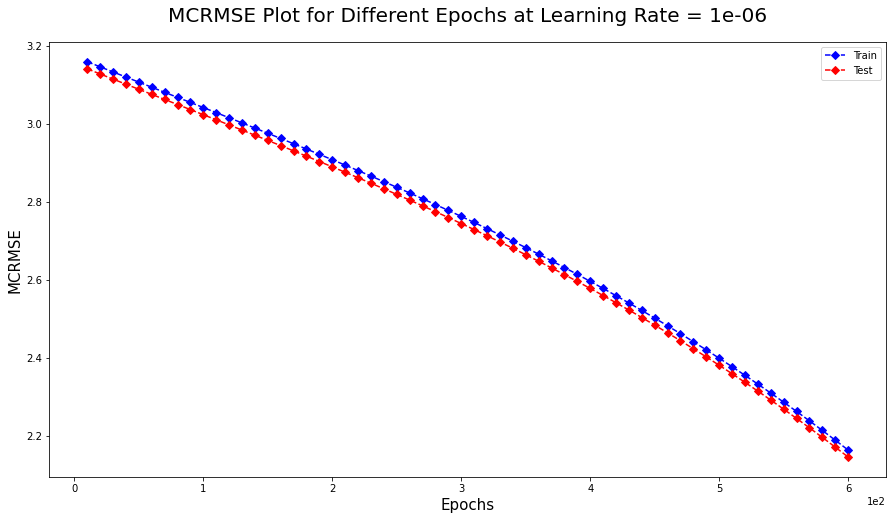

Initiating the network for learning rate: 1e-05
Train MCRMSE Info for Epochs = 100 is: (0.98413134, [0.95199823, 0.97840524, 0.9900637, 0.97813714, 1.0035126, 1.0026711])
Train MCRMSE Info for Epochs = 200 is: (0.6544737, [0.6626074, 0.64567906, 0.5881242, 0.6574822, 0.7040589, 0.6688904])
Train MCRMSE Info for Epochs = 300 is: (0.65132815, [0.6596294, 0.6425364, 0.5848498, 0.6541349, 0.7009979, 0.6658204])
Train MCRMSE Info for Epochs = 400 is: (0.6483405, [0.6567522, 0.6395561, 0.581815, 0.6509116, 0.69807893, 0.6629296])
Train MCRMSE Info for Epochs = 500 is: (0.6454508, [0.65397376, 0.63667256, 0.57888734, 0.64779097, 0.6952514, 0.6601283])
Train MCRMSE Info for Epochs = 600 is: (0.64265054, [0.6512869, 0.6338774, 0.5760576, 0.6447647, 0.692508, 0.6574088])


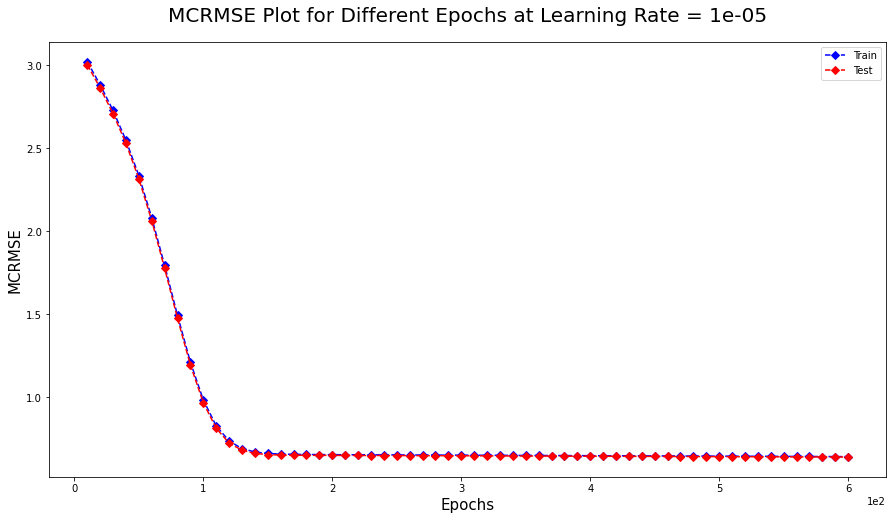

Initiating the network for learning rate: 0.0001
Train MCRMSE Info for Epochs = 100 is: (0.63339347, [0.6435279, 0.62477475, 0.5667871, 0.6356539, 0.6822959, 0.6473213])
Train MCRMSE Info for Epochs = 200 is: (0.61132187, [0.62345004, 0.6024891, 0.54539347, 0.6124042, 0.6588941, 0.62530005])
Train MCRMSE Info for Epochs = 300 is: (0.59329766, [0.6073077, 0.5842785, 0.5284282, 0.5931548, 0.6398273, 0.60678935])
Train MCRMSE Info for Epochs = 400 is: (0.5788465, [0.59455526, 0.5696955, 0.5152644, 0.5775883, 0.6246214, 0.5913542])
Train MCRMSE Info for Epochs = 500 is: (0.56776017, [0.5849037, 0.55856174, 0.5054303, 0.56566566, 0.6130841, 0.57891566])
Train MCRMSE Info for Epochs = 600 is: (0.55954844, [0.57780087, 0.55038065, 0.49828678, 0.5569804, 0.60469866, 0.5691435])


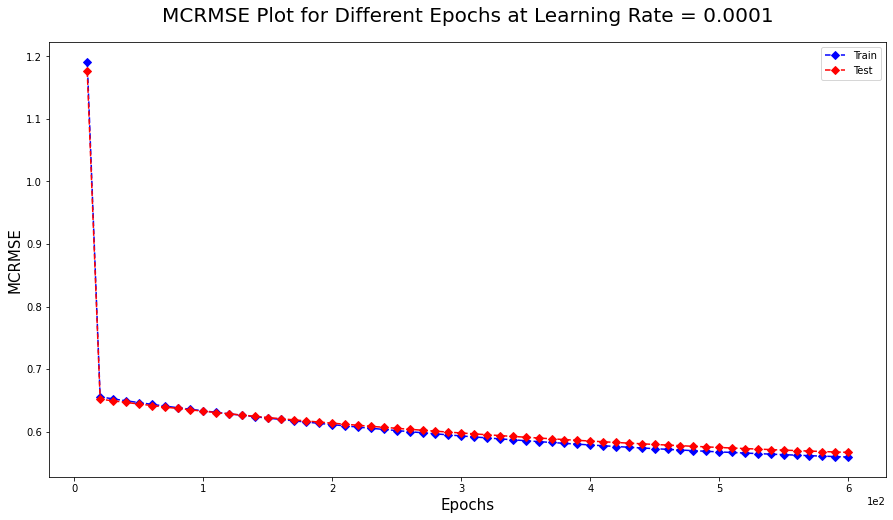

Initiating the network for learning rate: 0.001
Train MCRMSE Info for Epochs = 100 is: (0.5443656, [0.56344, 0.5359968, 0.4849492, 0.5413136, 0.591077, 0.5494171])
Train MCRMSE Info for Epochs = 200 is: (0.5295901, [0.54977715, 0.5214284, 0.47260457, 0.5290532, 0.5763064, 0.5283708])
Train MCRMSE Info for Epochs = 300 is: (0.51954776, [0.54073155, 0.5116276, 0.46464637, 0.5197184, 0.5640082, 0.51655436])
Train MCRMSE Info for Epochs = 400 is: (0.5110402, [0.5332536, 0.5032815, 0.45751852, 0.5115114, 0.5537426, 0.5069337])
Train MCRMSE Info for Epochs = 500 is: (0.503563, [0.5267282, 0.49595517, 0.4512225, 0.50389963, 0.54495424, 0.49861786])
Train MCRMSE Info for Epochs = 600 is: (0.49691796, [0.5207918, 0.48941115, 0.44546744, 0.4971482, 0.5374858, 0.49120328])


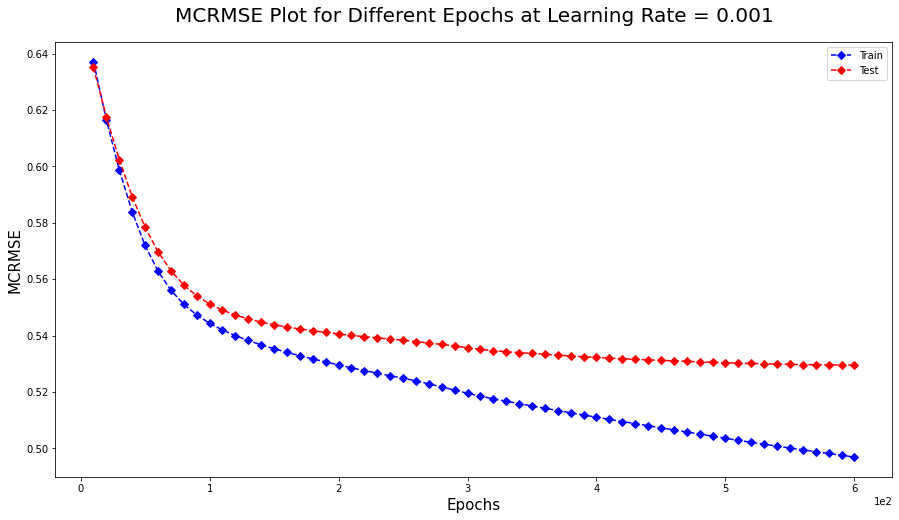

Initiating the network for learning rate: 0.01
Train MCRMSE Info for Epochs = 100 is: (0.4846611, [0.5116236, 0.47581488, 0.43184957, 0.4852118, 0.5221899, 0.48127702])
Train MCRMSE Info for Epochs = 200 is: (0.45381033, [0.4835745, 0.44612592, 0.40694386, 0.4539391, 0.48554865, 0.44673])
Train MCRMSE Info for Epochs = 300 is: (0.41459194, [0.44217956, 0.40648454, 0.37691414, 0.41515118, 0.43928745, 0.40753493])
Train MCRMSE Info for Epochs = 400 is: (0.38574687, [0.40998155, 0.3779597, 0.35537365, 0.38891792, 0.4053349, 0.37691346])
Train MCRMSE Info for Epochs = 500 is: (0.33838916, [0.35548687, 0.3312072, 0.3172507, 0.3375136, 0.35417792, 0.33469877])
Train MCRMSE Info for Epochs = 600 is: (0.3604989, [0.35968393, 0.3604964, 0.33126333, 0.34584385, 0.38862672, 0.37707904])


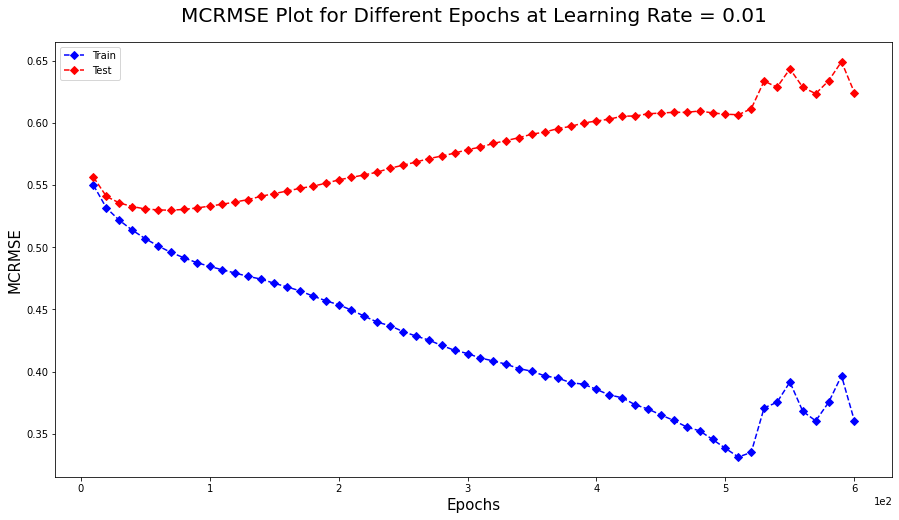

Observing MCRMSE with Change in Learning Rate
For Train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


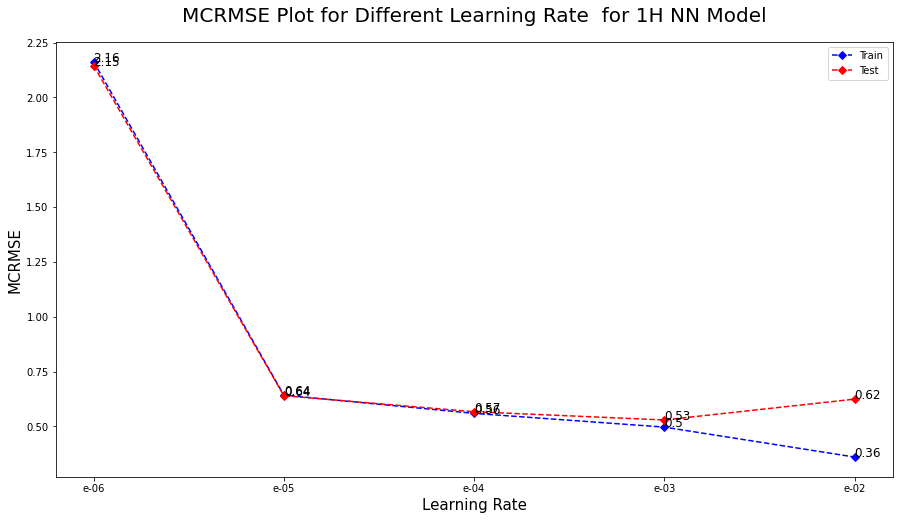

Generating Results Table
Generating Lowest Test MCRMSE Table


,Netowrk Type,Learning Rate,Epochs,Train MCRMSE,Test MCRMSE,cohesion Test RMSE,syntax Test RMSE,vocabulary Test RMSE,phraseology Test RMSE,grammar Test RMSE,conventions Test RMSE
0,1H NN,e-06,600,2.162848,2.145008,2.192171,2.087416,2.174398,2.224936,2.084079,2.107049
1,1H NN,e-05,600,0.642651,0.640093,0.623318,0.633985,0.558009,0.649567,0.694887,0.680794
2,1H NN,e-04,600,0.559548,0.566933,0.562290,0.559940,0.492834,0.575362,0.612066,0.599105
3,1H NN,e-03,600,0.496918,0.529544,0.530507,0.527405,0.457255,0.542773,0.573337,0.545985
4,1H NN,e-02,70,0.495888,0.529799,0.533084,0.527055,0.456422,0.543671,0.574479,0.544081


In [ ]:
##########--Predefined parameters--####################
# Update Before Running the block
epochs = 600
batch_size = 32
momentum = 0.9
learning_rate = np.logspace(-6,-2,num=5,base=10)
#######################################################
train_mcrmse_with_lr = []
test_mcrmse_with_lr = []
measure_rmse= []
lowest_test_mcrmse_list = []
lowest_test_mcrmse_train_list = []
lowest_mcrmse_epoch_list = []
lowest_test_measure_list = []
# Plot for Changing Learning Rate

for lrate in learning_rate:
  print("Initiating the network for learning rate:",lrate)
  #for plotting
  train_mcrmse = []
  test_mcrmse = []
  epochs_list = []
  lowest_test_mcrmse = 100
  lowest_mcrmse_measure = []
  lowest_mcrmse_epoch = 0

  #training block starts here--
  num_examples = trX.shape[0]
  num_examples
  num_batches = num_examples // batch_size

  #initiating the net class
  net = Net(768,100,6)
  criterion = nn.MSELoss()
  optimizer = optim.SGD(net.parameters(), lr=lrate, momentum=momentum)
  for e in range(1, epochs+1):
      loss = 0.
      for k in range(num_batches):
          start, end = k * batch_size, (k + 1) * batch_size
          loss += train(net,criterion,optimizer, trX[start:end], trY[start:end])
      train_correct = predict(net, trX, trY)
      test_correct = predict(net, teX, teY)
      
      if e%10==0 and e%100!=0 and e%epochs!=0:
        #print("Train MCRMSE Info for Epochs =",e,"is:",mcrmse(trY.detach().numpy(), train_correct.detach().numpy()))
        train_mcrmse.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        epochs_list.append(e)
      elif e%100==0 and e%epochs!=0:
        print("Train MCRMSE Info for Epochs =",e,"is:",mcrmse(trY.detach().numpy(), train_correct.detach().numpy()))
        train_mcrmse.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        epochs_list.append(e)
      elif e%epochs ==0:
        print("Train MCRMSE Info for Epochs =",e,"is:",mcrmse(trY.detach().numpy(), train_correct.detach().numpy()))
        train_mcrmse.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        #For learning rate curve
        train_mcrmse_with_lr.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse_with_lr.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        measure_rmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[1])
        epochs_list.append(e)
        #For saving minimum test mcrmse
      if lowest_test_mcrmse > mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0]:
        lowest_test_mcrmse = np.min([lowest_test_mcrmse,mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0]])
        lowest_test_mcrmse_train = mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0]
        lowest_mcrmse_epoch = e
        lowest_mcrmse_measure = mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[1]
      else: pass
  # plt.plot(train_mcrmse)
  # plt.xlabel('Epochs')
  # plt.ylabel('MCRMSE (On Train set)')
  # plt.show()

  # Saving lowest mcrmse parameters
  lowest_test_mcrmse_list.append(lowest_test_mcrmse)
  lowest_mcrmse_epoch_list.append(lowest_mcrmse_epoch)
  lowest_test_measure_list.append(lowest_mcrmse_measure)
  lowest_test_mcrmse_train_list.append(lowest_test_mcrmse_train)

  # Train vs Test Plot for different Epochs for a given Learning rate
  plt.figure(figsize=(15,8))
  plt.plot(epochs_list,train_mcrmse, '--', color = 'b', marker = 'D', label = "Train")
  plt.plot(epochs_list,test_mcrmse, '--', color = 'r', marker = 'D', label = "Test")
  plt.ylabel("MCRMSE", fontsize = 15)
  plt.xlabel("Epochs", fontsize = 15)
  plt.ticklabel_format(axis='x', style = 'sci', scilimits = (-6,-2))
  plt.title("MCRMSE Plot for Different Epochs at Learning Rate = {}".format(lrate), fontsize = 20, pad = 20)
  plt.legend()
  plt.show()
  # for index in range(len(epochs)):
  #   ax.text(learning_rate[index], train_mcrmse[index], round(train_mcrmse[index],2), size=12)


  # plt.plot(test_mcrmse)
  # plt.xlabel('Epochs')
  # plt.ylabel('MCRMSE (On test set)')
  # plt.show()

print("Observing MCRMSE with Change in Learning Rate")
learning_rate = ['e-06','e-05','e-04','e-03','e-02']
print("For Train")

fig = plt.figure(figsize=(15,8))
plt.plot(learning_rate,train_mcrmse_with_lr, '--', color = 'b', marker = 'D', label = "Train")
plt.plot(learning_rate,test_mcrmse_with_lr, '--', color = 'r', marker = 'D', label = "Test")
plt.ylabel("MCRMSE", fontsize = 15)
plt.xlabel("Learning Rate", fontsize = 15)
plt.title("MCRMSE Plot for Different Learning Rate  for 1H NN Model", fontsize = 20, pad = 20)
ax = fig.add_subplot(111)
for index in range(len(learning_rate)):
  ax.text(learning_rate[index], train_mcrmse_with_lr[index], round(train_mcrmse_with_lr[index],2), size=12)
for index in range(len(learning_rate)):
  ax.text(learning_rate[index], test_mcrmse_with_lr[index], round(test_mcrmse_with_lr[index],2), size=12)
plt.legend()
plt.show()


# fig, ax = plt.subplots(figsize=(15,8))
# ax.plot(learning_rate,train_mcrmse_with_lr, '--', color = 'b', marker = 'D')
# ax.set_ylabel("MCRMSE", fontsize = 15)
# ax.set_xlabel("Learning Rate", fontsize = 15)
# ax.set_title("Train MCRMSE Plot for different Learning Rate", fontsize = 20, pad = 20)
# for index in range(len(learning_rate)):
#   ax.text(learning_rate[index], train_mcrmse_with_lr[index], round(train_mcrmse_with_lr[index],2), size=12)

# print("For Test")
# fig, ax = plt.subplots(figsize=(15,8))
# ax.plot(learning_rate,test_mcrmse_with_lr, '--', color = 'b', marker = 'D')
# ax.set_ylabel("MCRMSE", fontsize = 15)
# ax.set_xlabel("Learning Rate", fontsize = 15)
# ax.set_title("Test MCRMSE Plot for different Learning Rate", fontsize = 20, pad = 20)
# for index in range(len(learning_rate)):
#   ax.text(learning_rate[index], test_mcrmse_with_lr[index], round(test_mcrmse_with_lr[index],2), size=12)

print("Generating Results Table")
results_table = pd.DataFrame(
    {"Netowrk Type":"1H NN",
     "Learning Rate":learning_rate,
     "Train MCRMSE": train_mcrmse_with_lr,
     "Test MCRMSE": test_mcrmse_with_lr,
     "Measure Test RMSE": measure_rmse
     }
     )
results_table[["cohesion Test RMSE", "syntax Test RMSE", "vocabulary Test RMSE", "phraseology Test RMSE", "grammar Test RMSE", "conventions Test RMSE"]] = pd.DataFrame(results_table["Measure Test RMSE"].tolist(), index= results_table.index)
results_table.drop(["Measure Test RMSE"], axis=1)

print("Generating Lowest Test MCRMSE Table")
test_table = pd.DataFrame(
    {"Netowrk Type":"1H NN",
     "Learning Rate":learning_rate,
     "Epochs":lowest_mcrmse_epoch_list,
     "Train MCRMSE": lowest_test_mcrmse_train_list,
     "Test MCRMSE":   lowest_test_mcrmse_list,
     "Measure Test RMSE": lowest_test_measure_list
     }
     )
test_table[["cohesion Test RMSE", "syntax Test RMSE", "vocabulary Test RMSE", "phraseology Test RMSE", "grammar Test RMSE", "conventions Test RMSE"]] = pd.DataFrame(test_table["Measure Test RMSE"].tolist(), index= test_table.index)
test_table.drop(["Measure Test RMSE"], axis=1)

2 Hidden Layer NN

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        
        #self.logsoftmax = nn.LogSoftmax()
        
    def forward(self, x):
        x = F.relu(self.i2h(x))
        x = F.relu(self.h2h(x))
        x = self.h2o(x)
        return x

Initiating the network for learning rate: 1e-06
Train MCRMSE Info for Epochs = 100 is: (3.0377579, [2.9989767, 2.970188, 3.179638, 3.0473762, 3.061349, 2.9690208])
Train MCRMSE Info for Epochs = 200 is: (2.8958063, [2.862102, 2.831838, 3.0266485, 2.9097047, 2.9144466, 2.8300989])
Train MCRMSE Info for Epochs = 300 is: (2.7472022, [2.71725, 2.6870995, 2.865906, 2.761679, 2.7630546, 2.6882248])
Train MCRMSE Info for Epochs = 400 is: (2.5768163, [2.5511744, 2.5217428, 2.6816719, 2.5887814, 2.5908, 2.5267272])
Train MCRMSE Info for Epochs = 500 is: (2.369955, [2.3494737, 2.3212416, 2.458645, 2.3769612, 2.382018, 2.3313916])
Train MCRMSE Info for Epochs = 600 is: (2.1092389, [2.0948126, 2.0667653, 2.1770082, 2.1103284, 2.1207163, 2.0858033])


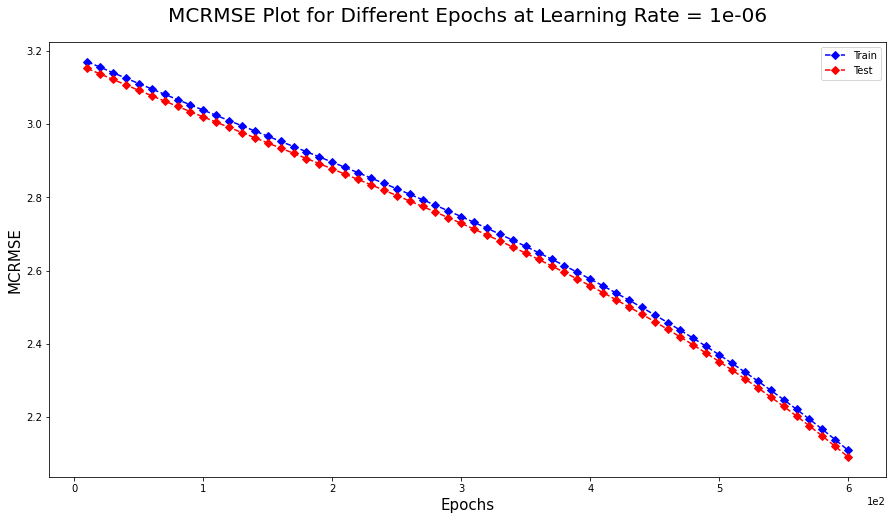

Initiating the network for learning rate: 1e-05
Train MCRMSE Info for Epochs = 100 is: (0.67042613, [0.6798593, 0.66423523, 0.5946176, 0.6790296, 0.71048385, 0.69433147])
Train MCRMSE Info for Epochs = 200 is: (0.650338, [0.6609967, 0.6418865, 0.5828536, 0.65263444, 0.69878536, 0.66487145])
Train MCRMSE Info for Epochs = 300 is: (0.64689744, [0.6576016, 0.63855505, 0.5793416, 0.649231, 0.69530714, 0.66134804])
Train MCRMSE Info for Epochs = 400 is: (0.643573, [0.6543354, 0.6353343, 0.5759519, 0.64591944, 0.6919502, 0.65794677])
Train MCRMSE Info for Epochs = 500 is: (0.6403286, [0.6511592, 0.63218856, 0.57264984, 0.64266384, 0.6886779, 0.6546322])
Train MCRMSE Info for Epochs = 600 is: (0.63713557, [0.6480453, 0.62908936, 0.56940615, 0.63943744, 0.685462, 0.6513733])


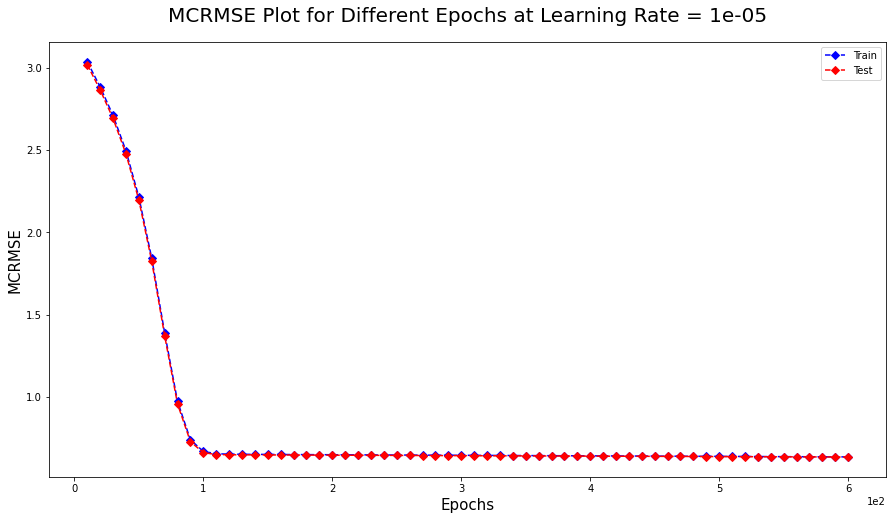

Initiating the network for learning rate: 0.0001
Train MCRMSE Info for Epochs = 100 is: (0.6300654, [0.64168364, 0.6215924, 0.5625844, 0.6317792, 0.67789024, 0.64486223])
Train MCRMSE Info for Epochs = 200 is: (0.59931576, [0.61240935, 0.59114057, 0.532682, 0.5990658, 0.6472227, 0.61337423])
Train MCRMSE Info for Epochs = 300 is: (0.57053727, [0.58642447, 0.5620206, 0.5069503, 0.56774646, 0.61779654, 0.5822849])
Train MCRMSE Info for Epochs = 400 is: (0.5538101, [0.5722634, 0.54482394, 0.49315763, 0.55020726, 0.6005113, 0.56189704])
Train MCRMSE Info for Epochs = 500 is: (0.5449, [0.56480086, 0.5357405, 0.48580182, 0.5418522, 0.59160537, 0.54959935])
Train MCRMSE Info for Epochs = 600 is: (0.53919715, [0.5598601, 0.5300452, 0.4809198, 0.53695315, 0.5859186, 0.54148597])


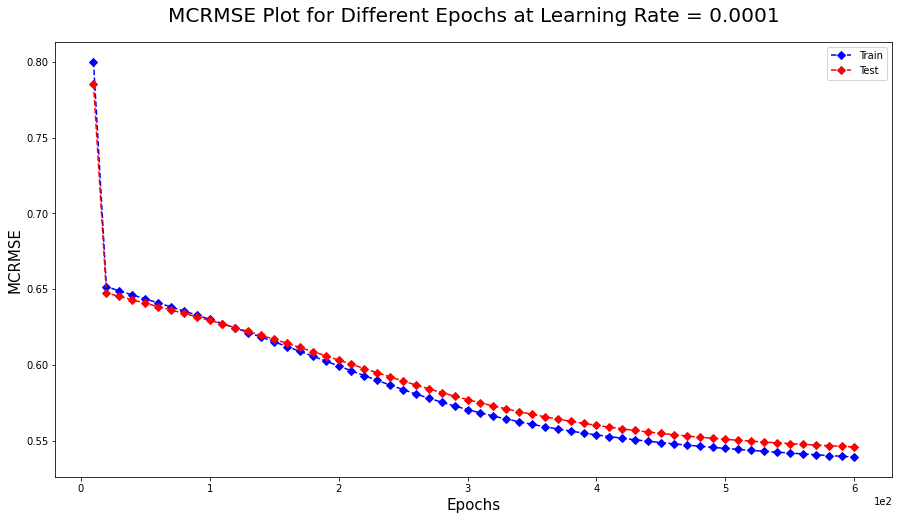

Initiating the network for learning rate: 0.001
Train MCRMSE Info for Epochs = 100 is: (0.52529544, [0.54761004, 0.516887, 0.46788287, 0.52400374, 0.57190305, 0.523486])
Train MCRMSE Info for Epochs = 200 is: (0.5020359, [0.52748656, 0.49159512, 0.44746, 0.50092995, 0.54708374, 0.49766007])
Train MCRMSE Info for Epochs = 300 is: (0.4827118, [0.5096134, 0.4710428, 0.43112835, 0.48079583, 0.5259178, 0.47777236])
Train MCRMSE Info for Epochs = 400 is: (0.4627205, [0.4899236, 0.45047465, 0.41456223, 0.45978355, 0.5032118, 0.45836744])
Train MCRMSE Info for Epochs = 500 is: (0.43912074, [0.46553117, 0.42677462, 0.39572042, 0.43352073, 0.47545192, 0.4377255])
Train MCRMSE Info for Epochs = 600 is: (0.4121969, [0.43699113, 0.4001736, 0.37445644, 0.40275356, 0.44334045, 0.41546622])


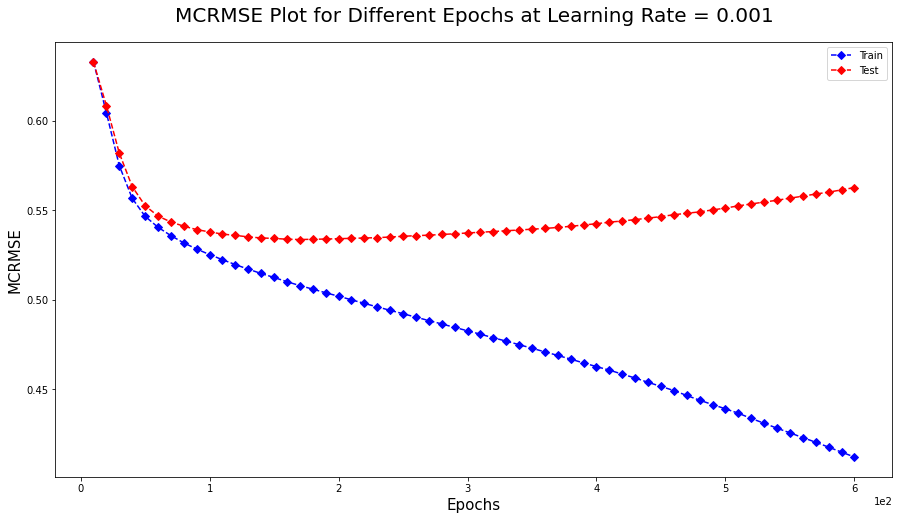

Initiating the network for learning rate: 0.01
Train MCRMSE Info for Epochs = 100 is: (0.4529905, [0.48024395, 0.4393557, 0.40736988, 0.44346046, 0.47764483, 0.4698682])
Train MCRMSE Info for Epochs = 200 is: (0.37975988, [0.40201193, 0.37750947, 0.35087332, 0.36677003, 0.39485213, 0.3865423])
Train MCRMSE Info for Epochs = 300 is: (0.42213646, [0.47370487, 0.42911294, 0.3938986, 0.4297713, 0.39919493, 0.4071363])
Train MCRMSE Info for Epochs = 400 is: (0.33039597, [0.31160253, 0.33229217, 0.307479, 0.35399595, 0.33440962, 0.34259668])
Train MCRMSE Info for Epochs = 500 is: (0.320549, [0.31383345, 0.31111628, 0.27835575, 0.32330874, 0.31799772, 0.37868232])
Train MCRMSE Info for Epochs = 600 is: (0.35169914, [0.39644113, 0.35787815, 0.34839442, 0.38204774, 0.31897986, 0.30645362])


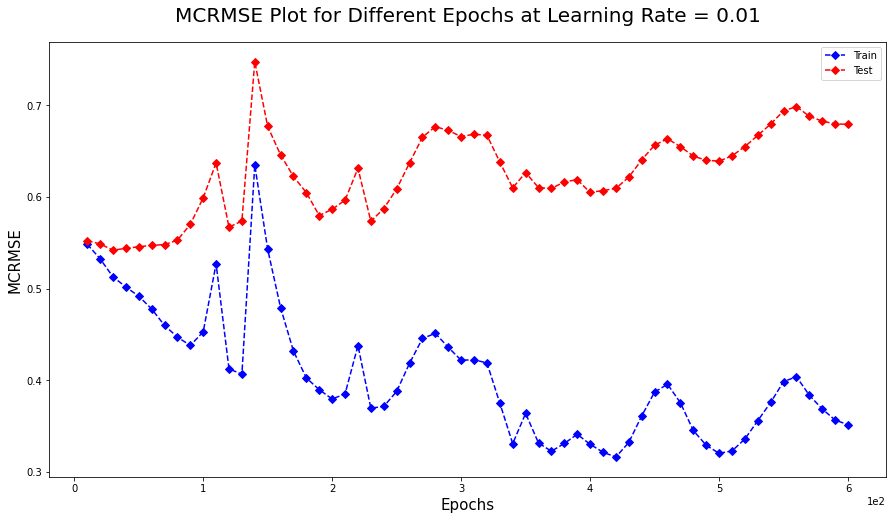

Observing MCRMSE with Change in Learning Rate
For Train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


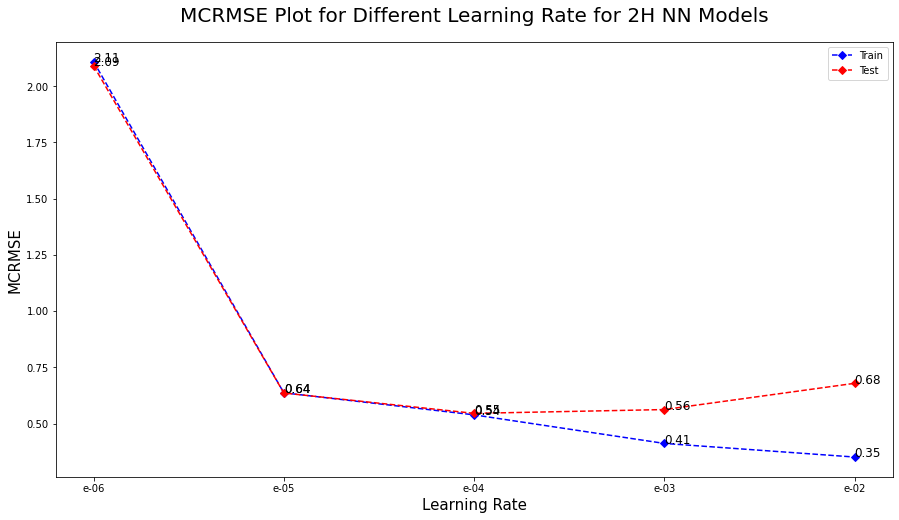

Generating Results Table
Generating Lowest Test MCRMSE Table


,Netowrk Type,Learning Rate,Epochs,Train MCRMSE,Test MCRMSE,cohesion Test RMSE,syntax Test RMSE,vocabulary Test RMSE,phraseology Test RMSE,grammar Test RMSE,conventions Test RMSE
0,2H NN,e-06,600,2.109239,2.090945,2.082688,2.046733,2.130094,2.102187,2.129521,2.054445
1,2H NN,e-05,600,0.637136,0.636305,0.620239,0.632715,0.553497,0.646256,0.688941,0.676181
2,2H NN,e-04,600,0.539197,0.545843,0.543498,0.540234,0.475615,0.553025,0.590565,0.572121
3,2H NN,e-03,170,0.507965,0.533696,0.535481,0.528800,0.459949,0.546589,0.582703,0.548654
4,2H NN,e-02,34,0.507097,0.541493,0.552266,0.536067,0.462460,0.558187,0.587673,0.552303


In [ ]:
##########--Predefined parameters--####################
# Update Before Running the block
epochs = 600
batch_size = 32
momentum = 0.9
learning_rate = np.logspace(-6,-2,num=5,base=10)
#######################################################
train_mcrmse_with_lr = []
test_mcrmse_with_lr = []
measure_rmse= []
lowest_test_mcrmse_list = []
lowest_test_mcrmse_train_list = []
lowest_mcrmse_epoch_list = []
lowest_test_measure_list = []
# Plot for Changing Learning Rate

for lrate in learning_rate:
  print("Initiating the network for learning rate:",lrate)
  #for plotting
  train_mcrmse = []
  test_mcrmse = []
  epochs_list = []
  lowest_test_mcrmse = 100
  lowest_mcrmse_measure = []
  lowest_mcrmse_epoch = 0

  #training block starts here--
  num_examples = trX.shape[0]
  num_examples
  num_batches = num_examples // batch_size

  #initiating the net class
  net = Net(768,100,6)
  criterion = nn.MSELoss()
  optimizer = optim.SGD(net.parameters(), lr=lrate, momentum=momentum)
  for e in range(1, epochs+1):
      loss = 0.
      for k in range(num_batches):
          start, end = k * batch_size, (k + 1) * batch_size
          loss += train(net,criterion,optimizer, trX[start:end], trY[start:end])
      train_correct = predict(net, trX, trY)
      test_correct = predict(net, teX, teY)
      
      if e%10==0 and e%100!=0 and e%epochs!=0:
        #print("Train MCRMSE Info for Epochs =",e,"is:",mcrmse(trY.detach().numpy(), train_correct.detach().numpy()))
        train_mcrmse.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        epochs_list.append(e)
      elif e%100==0 and e%epochs!=0:
        print("Train MCRMSE Info for Epochs =",e,"is:",mcrmse(trY.detach().numpy(), train_correct.detach().numpy()))
        train_mcrmse.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        epochs_list.append(e)
      elif e%epochs ==0:
        print("Train MCRMSE Info for Epochs =",e,"is:",mcrmse(trY.detach().numpy(), train_correct.detach().numpy()))
        train_mcrmse.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        #For learning rate curve
        train_mcrmse_with_lr.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse_with_lr.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        measure_rmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[1])
        epochs_list.append(e)
        #For saving minimum test mcrmse
      if lowest_test_mcrmse > mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0]:
        lowest_test_mcrmse = np.min([lowest_test_mcrmse,mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0]])
        lowest_test_mcrmse_train = mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0]
        lowest_mcrmse_epoch = e
        lowest_mcrmse_measure = mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[1]
      else: pass
  # plt.plot(train_mcrmse)
  # plt.xlabel('Epochs')
  # plt.ylabel('MCRMSE (On Train set)')
  # plt.show()

  # Saving lowest mcrmse parameters
  lowest_test_mcrmse_list.append(lowest_test_mcrmse)
  lowest_mcrmse_epoch_list.append(lowest_mcrmse_epoch)
  lowest_test_measure_list.append(lowest_mcrmse_measure)
  lowest_test_mcrmse_train_list.append(lowest_test_mcrmse_train)

  # Train vs Test Plot for different Epochs for a given Learning rate
  plt.figure(figsize=(15,8))
  plt.plot(epochs_list,train_mcrmse, '--', color = 'b', marker = 'D', label = "Train")
  plt.plot(epochs_list,test_mcrmse, '--', color = 'r', marker = 'D', label = "Test")
  plt.ylabel("MCRMSE", fontsize = 15)
  plt.xlabel("Epochs", fontsize = 15)
  plt.ticklabel_format(axis='x', style = 'sci', scilimits = (-6,-2))
  plt.title("MCRMSE Plot for Different Epochs at Learning Rate = {}".format(lrate), fontsize = 20, pad = 20)
  plt.legend()
  plt.show()
  # for index in range(len(epochs)):
  #   ax.text(learning_rate[index], train_mcrmse[index], round(train_mcrmse[index],2), size=12)


  # plt.plot(test_mcrmse)
  # plt.xlabel('Epochs')
  # plt.ylabel('MCRMSE (On test set)')
  # plt.show()

print("Observing MCRMSE with Change in Learning Rate")
learning_rate = ['e-06','e-05','e-04','e-03','e-02']
print("For Train")

fig2 = plt.figure(figsize=(15,8))
plt.plot(learning_rate,train_mcrmse_with_lr, '--', color = 'b', marker = 'D', label = "Train")
plt.plot(learning_rate,test_mcrmse_with_lr, '--', color = 'r', marker = 'D', label = "Test")
plt.ylabel("MCRMSE", fontsize = 15)
plt.xlabel("Learning Rate", fontsize = 15)
plt.title("MCRMSE Plot for Different Learning Rate for 2H NN Models", fontsize = 20, pad = 20)
ax = fig2.add_subplot(111)
for index in range(len(learning_rate)):
  ax.text(learning_rate[index], train_mcrmse_with_lr[index], round(train_mcrmse_with_lr[index],2), size=12)
for index in range(len(learning_rate)):
  ax.text(learning_rate[index], test_mcrmse_with_lr[index], round(test_mcrmse_with_lr[index],2), size=12)
plt.legend()
plt.show()


# fig, ax = plt.subplots(figsize=(15,8))
# ax.plot(learning_rate,train_mcrmse_with_lr, '--', color = 'b', marker = 'D')
# ax.set_ylabel("MCRMSE", fontsize = 15)
# ax.set_xlabel("Learning Rate", fontsize = 15)
# ax.set_title("Train MCRMSE Plot for different Learning Rate", fontsize = 20, pad = 20)
# for index in range(len(learning_rate)):
#   ax.text(learning_rate[index], train_mcrmse_with_lr[index], round(train_mcrmse_with_lr[index],2), size=12)

# print("For Test")
# fig, ax = plt.subplots(figsize=(15,8))
# ax.plot(learning_rate,test_mcrmse_with_lr, '--', color = 'b', marker = 'D')
# ax.set_ylabel("MCRMSE", fontsize = 15)
# ax.set_xlabel("Learning Rate", fontsize = 15)
# ax.set_title("Test MCRMSE Plot for different Learning Rate", fontsize = 20, pad = 20)
# for index in range(len(learning_rate)):
#   ax.text(learning_rate[index], test_mcrmse_with_lr[index], round(test_mcrmse_with_lr[index],2), size=12)

print("Generating Results Table")
results_table2 = pd.DataFrame(
    {"Netowrk Type":"2H NN",
     "Learning Rate":learning_rate,
     "Train MCRMSE": train_mcrmse_with_lr,
     "Test MCRMSE": test_mcrmse_with_lr,
     "Measure Test RMSE": measure_rmse
     }
     )
results_table2[["cohesion Test RMSE", "syntax Test RMSE", "vocabulary Test RMSE", "phraseology Test RMSE", "grammar Test RMSE", "conventions Test RMSE"]] = pd.DataFrame(results_table2["Measure Test RMSE"].tolist(), index= results_table2.index)
results_table2.drop(["Measure Test RMSE"], axis=1)

print("Generating Lowest Test MCRMSE Table")
test_table2 = pd.DataFrame(
    {"Netowrk Type":"2H NN",
     "Learning Rate":learning_rate,
     "Epochs":lowest_mcrmse_epoch_list,
     "Train MCRMSE": lowest_test_mcrmse_train_list,
     "Test MCRMSE":   lowest_test_mcrmse_list,
     "Measure Test RMSE": lowest_test_measure_list
     }
     )
test_table2[["cohesion Test RMSE", "syntax Test RMSE", "vocabulary Test RMSE", "phraseology Test RMSE", "grammar Test RMSE", "conventions Test RMSE"]] = pd.DataFrame(test_table2["Measure Test RMSE"].tolist(), index= test_table2.index)
test_table2.drop(["Measure Test RMSE"], axis=1)

3 hidden Layer

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2h2 = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        
        #self.logsoftmax = nn.LogSoftmax()
        
    def forward(self, x):
        x = F.relu(self.i2h(x))
        x = F.relu(self.h2h(x))
        x = F.relu(self.h2h2(x))
        x = self.h2o(x)
        return x

Initiating the network for learning rate: 1e-06
Train MCRMSE Info for Epochs = 100 is: (3.0409937, [3.115415, 2.985685, 3.1021726, 3.050761, 2.9539652, 3.0379632])
Train MCRMSE Info for Epochs = 200 is: (2.8651488, [2.9502602, 2.808659, 2.9246998, 2.8764715, 2.7821198, 2.848683])
Train MCRMSE Info for Epochs = 300 is: (2.652207, [2.7448192, 2.5897205, 2.70971, 2.6677911, 2.5773656, 2.6238346])
Train MCRMSE Info for Epochs = 400 is: (2.367686, [2.4683647, 2.2981548, 2.4206219, 2.3883793, 2.3061032, 2.3244922])
Train MCRMSE Info for Epochs = 500 is: (1.9697498, [2.076029, 1.8933604, 2.013905, 1.9960488, 1.9282074, 1.9109478])
Train MCRMSE Info for Epochs = 600 is: (1.4467291, [1.5513622, 1.3706567, 1.4716583, 1.474861, 1.4333026, 1.378533])


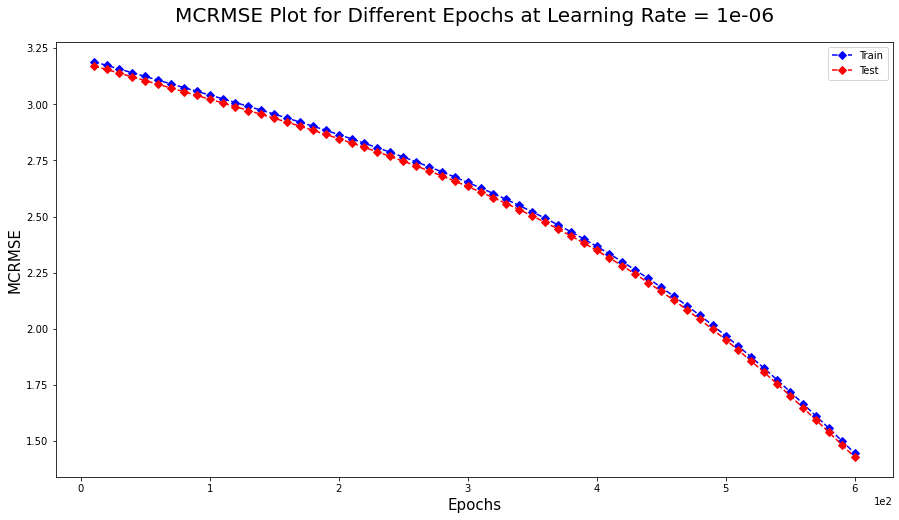

Initiating the network for learning rate: 1e-05
Train MCRMSE Info for Epochs = 100 is: (0.6586606, [0.6714393, 0.6466236, 0.5871027, 0.6619431, 0.7068165, 0.67803854])
Train MCRMSE Info for Epochs = 200 is: (0.6518903, [0.6639417, 0.64260983, 0.5838478, 0.65411186, 0.6990041, 0.6678263])
Train MCRMSE Info for Epochs = 300 is: (0.6506923, [0.6627131, 0.6414514, 0.58267224, 0.65291697, 0.6977895, 0.6666107])
Train MCRMSE Info for Epochs = 400 is: (0.64945906, [0.6614515, 0.64025486, 0.5814768, 0.6516813, 0.6965223, 0.66536784])
Train MCRMSE Info for Epochs = 500 is: (0.64818805, [0.6601687, 0.6390262, 0.5802279, 0.65040493, 0.6952193, 0.6640814])
Train MCRMSE Info for Epochs = 600 is: (0.6468543, [0.6588258, 0.63773954, 0.5789021, 0.64906484, 0.6938647, 0.6627286])


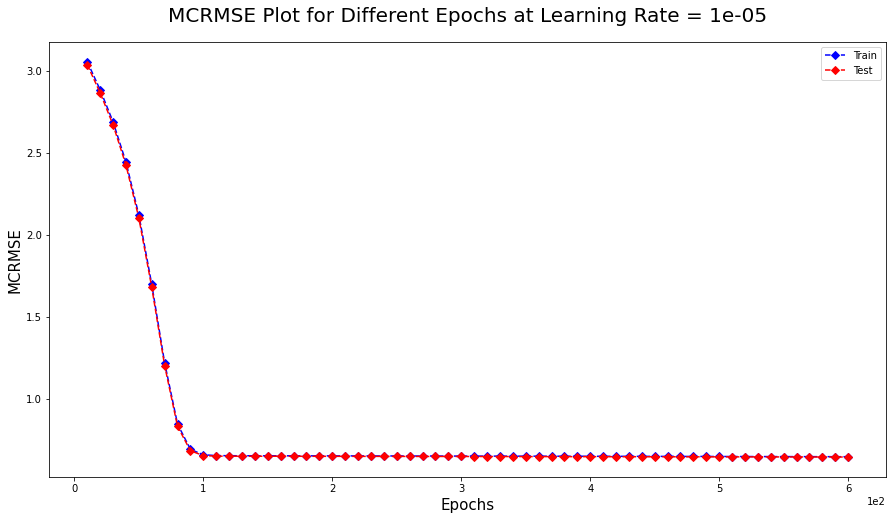

Initiating the network for learning rate: 0.0001
Train MCRMSE Info for Epochs = 100 is: (0.6336383, [0.64507693, 0.62524927, 0.56581354, 0.63570154, 0.6810718, 0.64891666])
Train MCRMSE Info for Epochs = 200 is: (0.59664583, [0.60902274, 0.5887848, 0.53021574, 0.5964364, 0.6445029, 0.6109126])
Train MCRMSE Info for Epochs = 300 is: (0.560816, [0.57762533, 0.5524657, 0.49847293, 0.5573455, 0.60796726, 0.5710195])
Train MCRMSE Info for Epochs = 400 is: (0.5439464, [0.5639511, 0.53505784, 0.48449212, 0.54072684, 0.59089893, 0.54855126])
Train MCRMSE Info for Epochs = 500 is: (0.5354286, [0.5565197, 0.52642965, 0.47690043, 0.5333498, 0.582701, 0.53667086])
Train MCRMSE Info for Epochs = 600 is: (0.52917784, [0.55088943, 0.52001166, 0.47129244, 0.5278536, 0.57671314, 0.5283067])


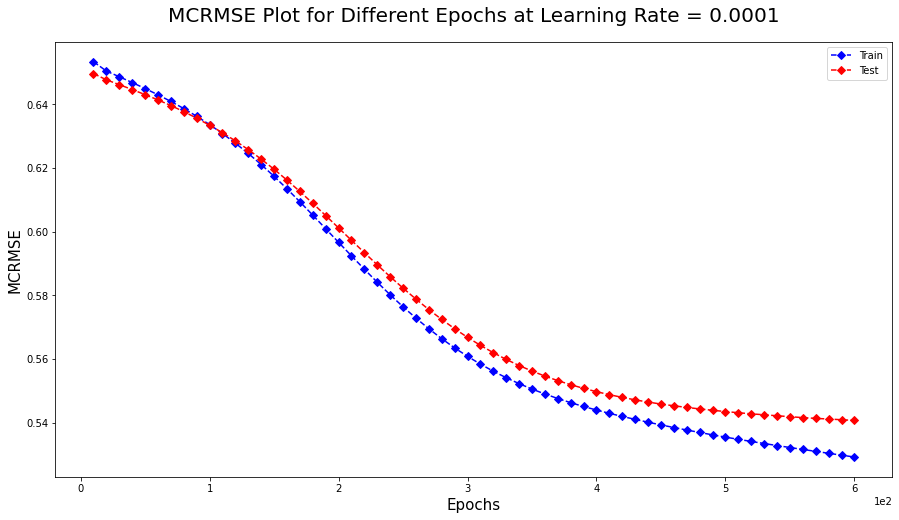

Initiating the network for learning rate: 0.001
Train MCRMSE Info for Epochs = 100 is: (0.51392686, [0.5376889, 0.50343394, 0.45806023, 0.51321965, 0.5605759, 0.51058245])
Train MCRMSE Info for Epochs = 200 is: (0.48729908, [0.5130194, 0.473469, 0.43660325, 0.48539063, 0.5301116, 0.48520055])
Train MCRMSE Info for Epochs = 300 is: (0.43968472, [0.46430925, 0.42301467, 0.39900792, 0.43271375, 0.4770517, 0.44201085])
Train MCRMSE Info for Epochs = 400 is: (0.38886836, [0.41146684, 0.37211582, 0.3593261, 0.37428954, 0.4174277, 0.3985842])
Train MCRMSE Info for Epochs = 500 is: (0.40707383, [0.42748263, 0.39083102, 0.37249824, 0.39642745, 0.4398801, 0.41532362])
Train MCRMSE Info for Epochs = 600 is: (0.37493107, [0.39633316, 0.35512173, 0.3477279, 0.3607412, 0.40225935, 0.38740307])


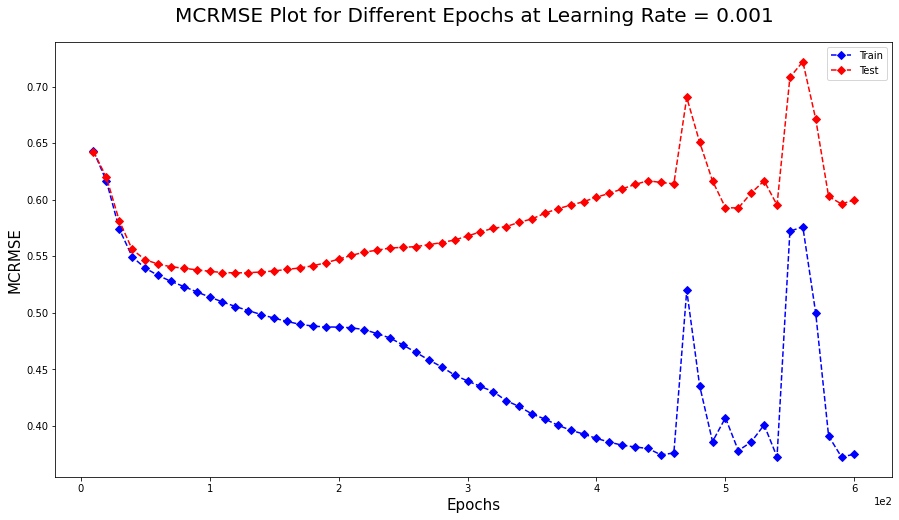

Initiating the network for learning rate: 0.01
Train MCRMSE Info for Epochs = 100 is: (0.46094596, [0.48213637, 0.4491907, 0.41545382, 0.45066178, 0.4971729, 0.47106034])
Train MCRMSE Info for Epochs = 200 is: (0.44499698, [0.45136493, 0.43808916, 0.4204208, 0.4364409, 0.4644476, 0.45921862])
Train MCRMSE Info for Epochs = 300 is: (0.33464667, [0.34519094, 0.34184316, 0.32063797, 0.32815996, 0.3263675, 0.34568056])
Train MCRMSE Info for Epochs = 400 is: (0.35007128, [0.37017646, 0.3709726, 0.32764924, 0.35842738, 0.3420062, 0.33119574])
Train MCRMSE Info for Epochs = 500 is: (0.28975204, [0.2740957, 0.32859713, 0.2718793, 0.29887524, 0.30780032, 0.25726455])
Train MCRMSE Info for Epochs = 600 is: (0.32688144, [0.30192646, 0.36126322, 0.25218755, 0.2825837, 0.3705746, 0.39275318])


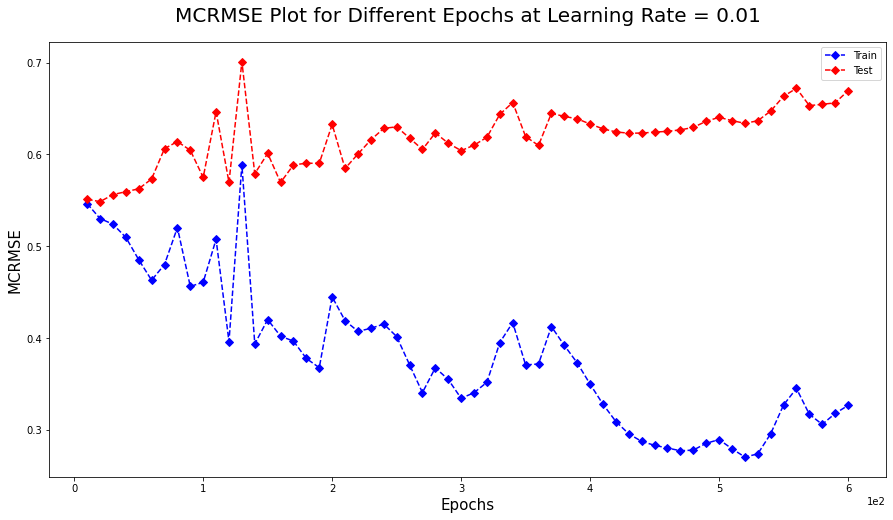

Observing MCRMSE with Change in Learning Rate
For Train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


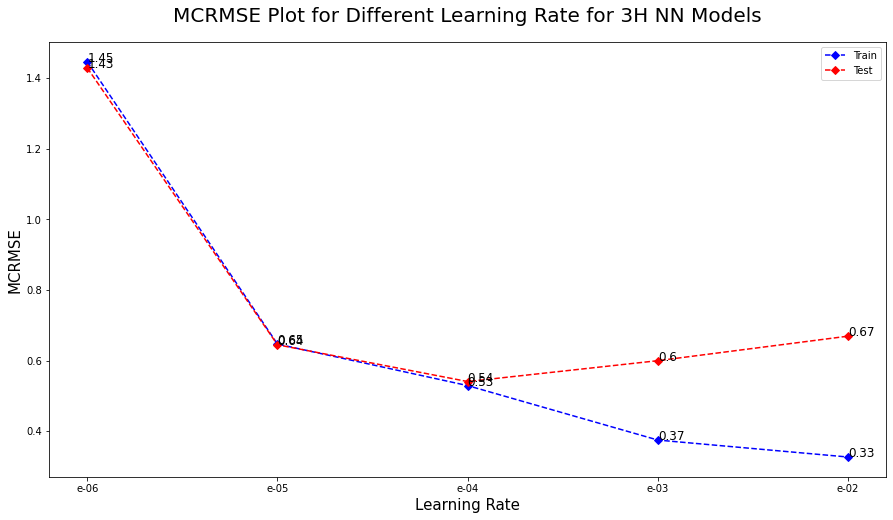

Generating Results Table
Generating Lowest Test MCRMSE Table


,Netowrk Type,Learning Rate,Epochs,Train MCRMSE,Test MCRMSE,cohesion Test RMSE,syntax Test RMSE,vocabulary Test RMSE,phraseology Test RMSE,grammar Test RMSE,conventions Test RMSE
0,3H NN,e-06,600,1.446729,1.429262,1.535716,1.352623,1.424059,1.467712,1.441940,1.353524
1,3H NN,e-05,600,0.646854,0.644819,0.628535,0.643180,0.560573,0.655700,0.695648,0.685280
2,3H NN,e-04,600,0.529178,0.540684,0.541199,0.534197,0.470322,0.549782,0.586722,0.561881
3,3H NN,e-03,118,0.506272,0.535228,0.539329,0.528699,0.462357,0.547648,0.583817,0.549518
4,3H NN,e-02,21,0.528449,0.548230,0.557698,0.542387,0.470409,0.564192,0.593726,0.560970


In [ ]:
##########--Predefined parameters--####################
# Update Before Running the block
epochs = 600
batch_size = 32
momentum = 0.9
learning_rate = np.logspace(-6,-2,num=5,base=10)
#######################################################
train_mcrmse_with_lr = []
test_mcrmse_with_lr = []
measure_rmse= []
lowest_test_mcrmse_list = []
lowest_test_mcrmse_train_list = []
lowest_mcrmse_epoch_list = []
lowest_test_measure_list = []
# Plot for Changing Learning Rate

for lrate in learning_rate:
  print("Initiating the network for learning rate:",lrate)
  #for plotting
  train_mcrmse = []
  test_mcrmse = []
  epochs_list = []
  lowest_test_mcrmse = 100
  lowest_mcrmse_measure = []
  lowest_mcrmse_epoch = 0

  #training block starts here--
  num_examples = trX.shape[0]
  num_examples
  num_batches = num_examples // batch_size

  #initiating the net class
  net = Net(768,100,6)
  criterion = nn.MSELoss()
  optimizer = optim.SGD(net.parameters(), lr=lrate, momentum=momentum)
  for e in range(1, epochs+1):
      loss = 0.
      for k in range(num_batches):
          start, end = k * batch_size, (k + 1) * batch_size
          loss += train(net,criterion,optimizer, trX[start:end], trY[start:end])
      train_correct = predict(net, trX, trY)
      test_correct = predict(net, teX, teY)
      
      if e%10==0 and e%100!=0 and e%epochs!=0:
        #print("Train MCRMSE Info for Epochs =",e,"is:",mcrmse(trY.detach().numpy(), train_correct.detach().numpy()))
        train_mcrmse.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        epochs_list.append(e)
      elif e%100==0 and e%epochs!=0:
        print("Train MCRMSE Info for Epochs =",e,"is:",mcrmse(trY.detach().numpy(), train_correct.detach().numpy()))
        train_mcrmse.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        epochs_list.append(e)
      elif e%epochs ==0:
        print("Train MCRMSE Info for Epochs =",e,"is:",mcrmse(trY.detach().numpy(), train_correct.detach().numpy()))
        train_mcrmse.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        #For learning rate curve
        train_mcrmse_with_lr.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse_with_lr.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        measure_rmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[1])
        epochs_list.append(e)
        #For saving minimum test mcrmse
      if lowest_test_mcrmse > mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0]:
        lowest_test_mcrmse = np.min([lowest_test_mcrmse,mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0]])
        lowest_test_mcrmse_train = mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0]
        lowest_mcrmse_epoch = e
        lowest_mcrmse_measure = mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[1]
      else: pass
  # plt.plot(train_mcrmse)
  # plt.xlabel('Epochs')
  # plt.ylabel('MCRMSE (On Train set)')
  # plt.show()

  # Saving lowest mcrmse parameters
  lowest_test_mcrmse_list.append(lowest_test_mcrmse)
  lowest_mcrmse_epoch_list.append(lowest_mcrmse_epoch)
  lowest_test_measure_list.append(lowest_mcrmse_measure)
  lowest_test_mcrmse_train_list.append(lowest_test_mcrmse_train)

  # Train vs Test Plot for different Epochs for a given Learning rate
  plt.figure(figsize=(15,8))
  plt.plot(epochs_list,train_mcrmse, '--', color = 'b', marker = 'D', label = "Train")
  plt.plot(epochs_list,test_mcrmse, '--', color = 'r', marker = 'D', label = "Test")
  plt.ylabel("MCRMSE", fontsize = 15)
  plt.xlabel("Epochs", fontsize = 15)
  plt.ticklabel_format(axis='x', style = 'sci', scilimits = (-6,-2))
  plt.title("MCRMSE Plot for Different Epochs at Learning Rate = {}".format(lrate), fontsize = 20, pad = 20)
  plt.legend()
  plt.show()
  # for index in range(len(epochs)):
  #   ax.text(learning_rate[index], train_mcrmse[index], round(train_mcrmse[index],2), size=12)


  # plt.plot(test_mcrmse)
  # plt.xlabel('Epochs')
  # plt.ylabel('MCRMSE (On test set)')
  # plt.show()


print("Observing MCRMSE with Change in Learning Rate")
learning_rate = ['e-06','e-05','e-04','e-03','e-02']
print("For Train")

fig3 = plt.figure(figsize=(15,8))
plt.plot(learning_rate,train_mcrmse_with_lr, '--', color = 'b', marker = 'D', label = "Train")
plt.plot(learning_rate,test_mcrmse_with_lr, '--', color = 'r', marker = 'D', label = "Test")
plt.ylabel("MCRMSE", fontsize = 15)
plt.xlabel("Learning Rate", fontsize = 15)
plt.title("MCRMSE Plot for Different Learning Rate for 3H NN Models", fontsize = 20, pad = 20)
ax = fig3.add_subplot(111)
for index in range(len(learning_rate)):
  ax.text(learning_rate[index], train_mcrmse_with_lr[index], round(train_mcrmse_with_lr[index],2), size=12)
for index in range(len(learning_rate)):
  ax.text(learning_rate[index], test_mcrmse_with_lr[index], round(test_mcrmse_with_lr[index],2), size=12)
plt.legend()
plt.show()


# fig, ax = plt.subplots(figsize=(15,8))
# ax.plot(learning_rate,train_mcrmse_with_lr, '--', color = 'b', marker = 'D')
# ax.set_ylabel("MCRMSE", fontsize = 15)
# ax.set_xlabel("Learning Rate", fontsize = 15)
# ax.set_title("Train MCRMSE Plot for different Learning Rate", fontsize = 20, pad = 20)
# for index in range(len(learning_rate)):
#   ax.text(learning_rate[index], train_mcrmse_with_lr[index], round(train_mcrmse_with_lr[index],2), size=12)

# print("For Test")
# fig, ax = plt.subplots(figsize=(15,8))
# ax.plot(learning_rate,test_mcrmse_with_lr, '--', color = 'b', marker = 'D')
# ax.set_ylabel("MCRMSE", fontsize = 15)
# ax.set_xlabel("Learning Rate", fontsize = 15)
# ax.set_title("Test MCRMSE Plot for different Learning Rate", fontsize = 20, pad = 20)
# for index in range(len(learning_rate)):
#   ax.text(learning_rate[index], test_mcrmse_with_lr[index], round(test_mcrmse_with_lr[index],2), size=12)

print("Generating Results Table")
results_table3 = pd.DataFrame(
    {"Netowrk Type":"3H NN",
     "Learning Rate":learning_rate,
     "Train MCRMSE": train_mcrmse_with_lr,
     "Test MCRMSE": test_mcrmse_with_lr,
     "Measure Test RMSE": measure_rmse
     }
     )
results_table3[["cohesion Test RMSE", "syntax Test RMSE", "vocabulary Test RMSE", "phraseology Test RMSE", "grammar Test RMSE", "conventions Test RMSE"]] = pd.DataFrame(results_table3["Measure Test RMSE"].tolist(), index= results_table3.index)
results_table3.drop(["Measure Test RMSE"], axis=1)

print("Generating Lowest Test MCRMSE Table")
test_table3 = pd.DataFrame(
    {"Netowrk Type":"3H NN",
     "Learning Rate":learning_rate,
     "Epochs":lowest_mcrmse_epoch_list,
     "Train MCRMSE": lowest_test_mcrmse_train_list,
     "Test MCRMSE":   lowest_test_mcrmse_list,
     "Measure Test RMSE": lowest_test_measure_list
     }
     )
test_table3[["cohesion Test RMSE", "syntax Test RMSE", "vocabulary Test RMSE", "phraseology Test RMSE", "grammar Test RMSE", "conventions Test RMSE"]] = pd.DataFrame(test_table3["Measure Test RMSE"].tolist(), index= test_table3.index)
test_table3.drop(["Measure Test RMSE"], axis=1)

#### 3 Hidden and 1 Dropout Layer

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.drop = nn.Dropout(p = 0.5)
        self.h2h2 = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        
        #self.logsoftmax = nn.LogSoftmax()
        
    def forward(self, x):
        x = F.relu(self.i2h(x))
        x = F.relu(self.h2h(x))
        x = F.relu(self.drop(x))
        x = F.relu(self.h2h2(x))
        x = self.h2o(x)
        return x

Initiating the network for learning rate: 1e-06
Train MCRMSE Info for Epochs = 100 is: (3.0511591, [3.009045, 2.9968543, 3.2380185, 3.0409367, 2.9872677, 3.0348346])
Train MCRMSE Info for Epochs = 200 is: (2.8965542, [2.849746, 2.8394823, 3.088044, 2.8814263, 2.8457615, 2.8748646])
Train MCRMSE Info for Epochs = 300 is: (2.7189047, [2.666027, 2.6615324, 2.9130852, 2.698937, 2.684429, 2.6894195])
Train MCRMSE Info for Epochs = 400 is: (2.4948485, [2.43476, 2.4384673, 2.6891193, 2.469736, 2.4827638, 2.454244])
Train MCRMSE Info for Epochs = 500 is: (2.1922264, [2.1243334, 2.1385875, 2.380084, 2.1629086, 2.2088528, 2.1385918])
Train MCRMSE Info for Epochs = 600 is: (1.7770182, [1.7036839, 1.7291901, 1.9458776, 1.7448211, 1.826276, 1.71226])


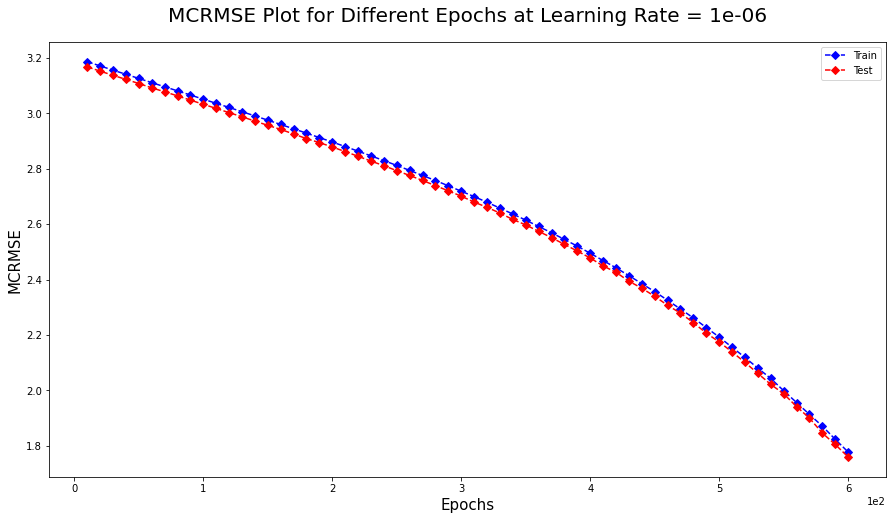

Initiating the network for learning rate: 1e-05
Train MCRMSE Info for Epochs = 100 is: (0.7273865, [0.74833894, 0.7255456, 0.6672007, 0.72664136, 0.75677377, 0.73981833])
Train MCRMSE Info for Epochs = 200 is: (0.6956977, [0.71182585, 0.6810213, 0.6372169, 0.6967549, 0.73826087, 0.7091065])
Train MCRMSE Info for Epochs = 300 is: (0.6926337, [0.7059116, 0.67970955, 0.6345347, 0.6889879, 0.7364771, 0.7101811])
Train MCRMSE Info for Epochs = 400 is: (0.68270725, [0.69644517, 0.67080414, 0.6218932, 0.6826972, 0.7249854, 0.6994184])
Train MCRMSE Info for Epochs = 500 is: (0.6739796, [0.68710124, 0.66408473, 0.61378145, 0.6771966, 0.7143232, 0.6873899])
Train MCRMSE Info for Epochs = 600 is: (0.67449117, [0.6894599, 0.6644656, 0.6113953, 0.6758397, 0.7183768, 0.6874095])


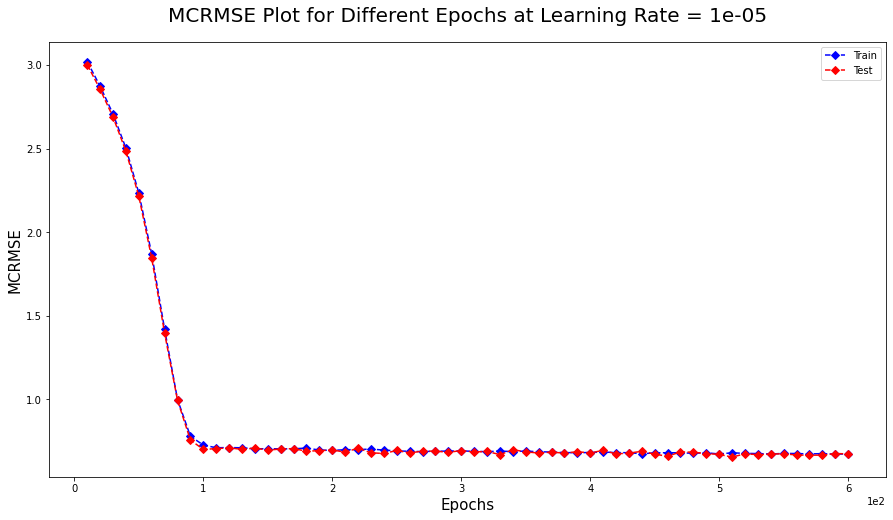

Initiating the network for learning rate: 0.0001
Train MCRMSE Info for Epochs = 100 is: (0.6539456, [0.6678897, 0.64329183, 0.58934605, 0.6573935, 0.69866157, 0.66709095])
Train MCRMSE Info for Epochs = 200 is: (0.63328415, [0.64661604, 0.62529963, 0.5650873, 0.63522923, 0.6797014, 0.64777136])
Train MCRMSE Info for Epochs = 300 is: (0.59120035, [0.605857, 0.5835805, 0.5262491, 0.5903423, 0.6377209, 0.6034523])
Train MCRMSE Info for Epochs = 400 is: (0.5669096, [0.5849174, 0.5591575, 0.50482136, 0.5629412, 0.612353, 0.5772673])
Train MCRMSE Info for Epochs = 500 is: (0.5565558, [0.5779354, 0.54779804, 0.4951921, 0.5533239, 0.6044161, 0.5606693])
Train MCRMSE Info for Epochs = 600 is: (0.5459989, [0.5680522, 0.5370935, 0.48554742, 0.5433265, 0.59266096, 0.54931295])


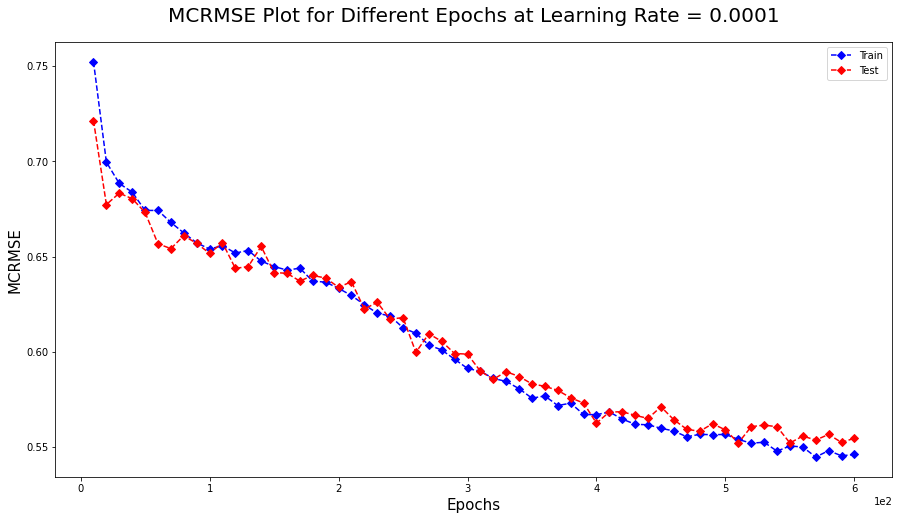

Initiating the network for learning rate: 0.001
Train MCRMSE Info for Epochs = 100 is: (0.53386515, [0.556463, 0.5240106, 0.47361246, 0.5344242, 0.578232, 0.5364484])
Train MCRMSE Info for Epochs = 200 is: (0.5021015, [0.5294126, 0.49024272, 0.44590905, 0.50141555, 0.5455872, 0.500042])
Train MCRMSE Info for Epochs = 300 is: (0.47632563, [0.5050714, 0.4624819, 0.4248559, 0.4712011, 0.5185988, 0.4757449])
Train MCRMSE Info for Epochs = 400 is: (0.45156455, [0.47622547, 0.4364624, 0.40924233, 0.4427602, 0.48655328, 0.4581436])
Train MCRMSE Info for Epochs = 500 is: (0.47386035, [0.49752, 0.45789218, 0.42716745, 0.4677811, 0.5049918, 0.4878096])
Train MCRMSE Info for Epochs = 600 is: (0.3992804, [0.42042446, 0.38341329, 0.367124, 0.38828713, 0.4327608, 0.40367255])


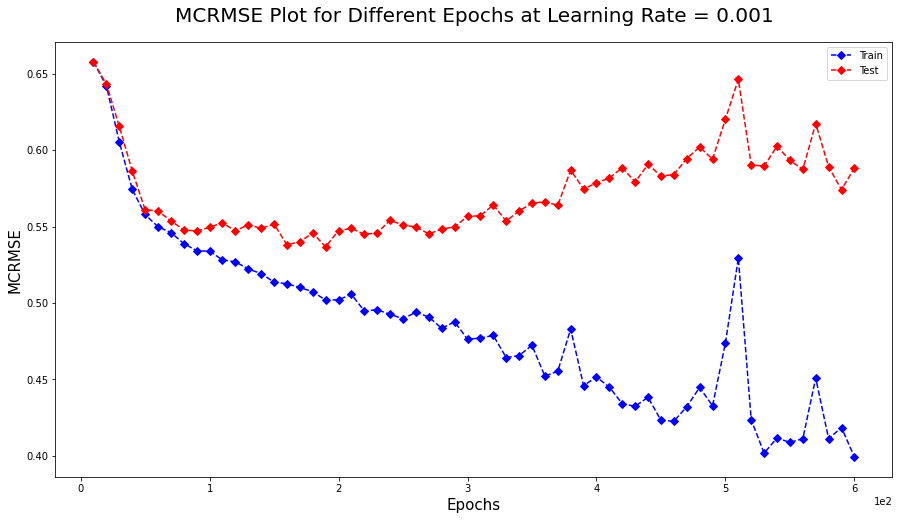

Initiating the network for learning rate: 0.01
Train MCRMSE Info for Epochs = 100 is: (0.51872903, [0.54278725, 0.504225, 0.4648493, 0.5183235, 0.55464625, 0.5275429])
Train MCRMSE Info for Epochs = 200 is: (0.44866028, [0.47511804, 0.43191564, 0.41580376, 0.4445352, 0.46975148, 0.45483768])
Train MCRMSE Info for Epochs = 300 is: (0.41819575, [0.44301248, 0.39959797, 0.38390547, 0.40815204, 0.44317397, 0.43133256])
Train MCRMSE Info for Epochs = 400 is: (0.4039998, [0.41943452, 0.3925952, 0.3699779, 0.39016327, 0.4346043, 0.41722378])
Train MCRMSE Info for Epochs = 500 is: (0.37576315, [0.38954696, 0.3632253, 0.35633653, 0.36754617, 0.38358054, 0.39434323])
Train MCRMSE Info for Epochs = 600 is: (0.35876045, [0.36402822, 0.35684782, 0.34552437, 0.35268897, 0.35318893, 0.38028437])


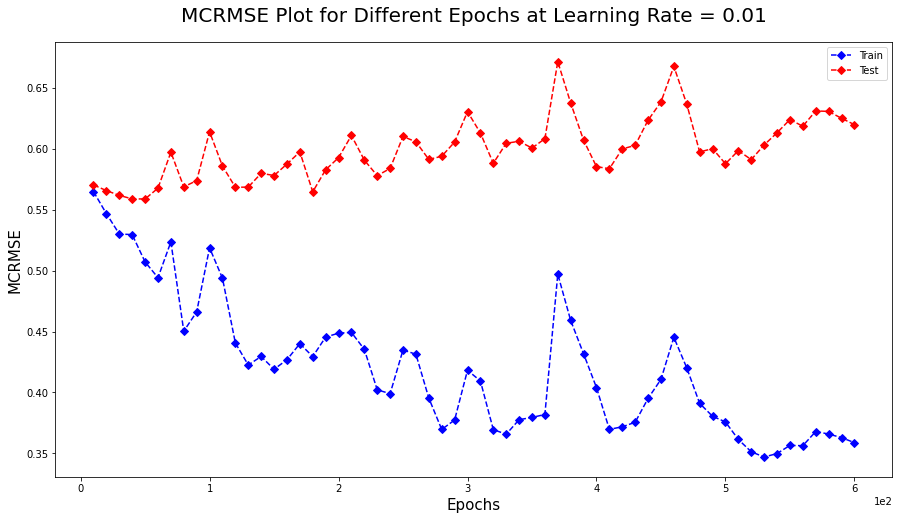

Observing MCRMSE with Change in Learning Rate
For Train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


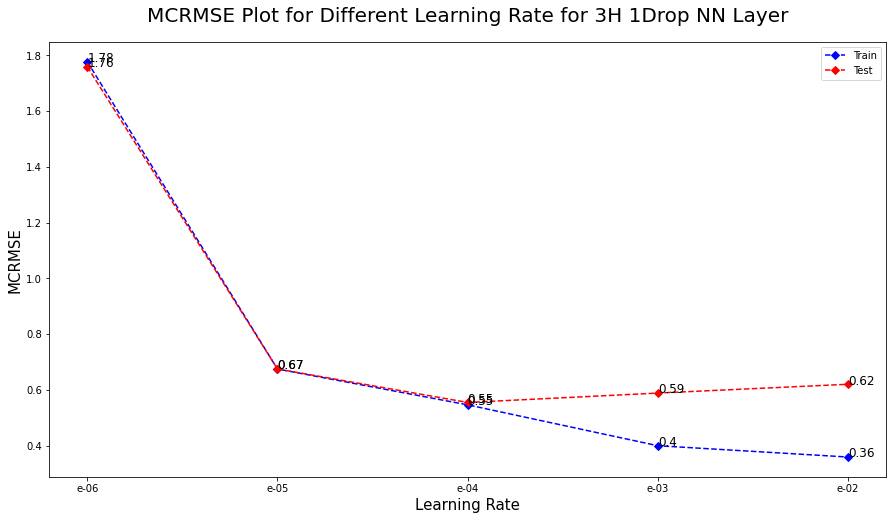

Generating Results Table
Generating Lowest Test MCRMSE Table


,Netowrk Type,Learning Rate,Epochs,Train MCRMSE,Test MCRMSE,cohesion Test RMSE,syntax Test RMSE,vocabulary Test RMSE,phraseology Test RMSE,grammar Test RMSE,conventions Test RMSE
0,3H 1 Drop NN,e-06,600,1.777018,1.759092,1.688284,1.713794,1.897301,1.737403,1.834763,1.683009
1,3H 1 Drop NN,e-05,495,0.675765,0.654206,0.648750,0.642645,0.577527,0.666218,0.699982,0.690113
2,3H 1 Drop NN,e-04,514,0.552068,0.546315,0.546257,0.539090,0.472716,0.553635,0.595215,0.570976
3,3H 1 Drop NN,e-03,226,0.496020,0.530929,0.537038,0.528377,0.454652,0.545306,0.577562,0.542639
4,3H 1 Drop NN,e-02,32,0.523741,0.549969,0.557994,0.543685,0.475812,0.564588,0.595061,0.562677


In [ ]:
##########--Predefined parameters--####################
# Update Before Running the block
epochs = 600
batch_size = 32
momentum = 0.9
learning_rate = np.logspace(-6,-2,num=5,base=10)
#######################################################
train_mcrmse_with_lr = []
test_mcrmse_with_lr = []
measure_rmse= []
lowest_test_mcrmse_list = []
lowest_test_mcrmse_train_list = []
lowest_mcrmse_epoch_list = []
lowest_test_measure_list = []
# Plot for Changing Learning Rate

for lrate in learning_rate:
  print("Initiating the network for learning rate:",lrate)
  #for plotting
  train_mcrmse = []
  test_mcrmse = []
  epochs_list = []
  lowest_test_mcrmse = 100
  lowest_mcrmse_measure = []
  lowest_mcrmse_epoch = 0

  #training block starts here--
  num_examples = trX.shape[0]
  num_examples
  num_batches = num_examples // batch_size

  #initiating the net class
  net = Net(768,100,6)
  criterion = nn.MSELoss()
  optimizer = optim.SGD(net.parameters(), lr=lrate, momentum=momentum)
  for e in range(1, epochs+1):
      loss = 0.
      for k in range(num_batches):
          start, end = k * batch_size, (k + 1) * batch_size
          loss += train(net,criterion,optimizer, trX[start:end], trY[start:end])
      train_correct = predict(net, trX, trY)
      test_correct = predict(net, teX, teY)
      
      if e%10==0 and e%100!=0 and e%epochs!=0:
        #print("Train MCRMSE Info for Epochs =",e,"is:",mcrmse(trY.detach().numpy(), train_correct.detach().numpy()))
        train_mcrmse.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        epochs_list.append(e)
      elif e%100==0 and e%epochs!=0:
        print("Train MCRMSE Info for Epochs =",e,"is:",mcrmse(trY.detach().numpy(), train_correct.detach().numpy()))
        train_mcrmse.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        epochs_list.append(e)
      elif e%epochs ==0:
        print("Train MCRMSE Info for Epochs =",e,"is:",mcrmse(trY.detach().numpy(), train_correct.detach().numpy()))
        train_mcrmse.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        #For learning rate curve
        train_mcrmse_with_lr.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse_with_lr.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        measure_rmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[1])
        epochs_list.append(e)
        #For saving minimum test mcrmse
      if lowest_test_mcrmse > mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0]:
        lowest_test_mcrmse = np.min([lowest_test_mcrmse,mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0]])
        lowest_test_mcrmse_train = mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0]
        lowest_mcrmse_epoch = e
        lowest_mcrmse_measure = mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[1]
      else: pass
  # plt.plot(train_mcrmse)
  # plt.xlabel('Epochs')
  # plt.ylabel('MCRMSE (On Train set)')
  # plt.show()

  # Saving lowest mcrmse parameters
  lowest_test_mcrmse_list.append(lowest_test_mcrmse)
  lowest_mcrmse_epoch_list.append(lowest_mcrmse_epoch)
  lowest_test_measure_list.append(lowest_mcrmse_measure)
  lowest_test_mcrmse_train_list.append(lowest_test_mcrmse_train)

  # Train vs Test Plot for different Epochs for a given Learning rate
  plt.figure(figsize=(15,8))
  plt.plot(epochs_list,train_mcrmse, '--', color = 'b', marker = 'D', label = "Train")
  plt.plot(epochs_list,test_mcrmse, '--', color = 'r', marker = 'D', label = "Test")
  plt.ylabel("MCRMSE", fontsize = 15)
  plt.xlabel("Epochs", fontsize = 15)
  plt.ticklabel_format(axis='x', style = 'sci', scilimits = (-6,-2))
  plt.title("MCRMSE Plot for Different Epochs at Learning Rate = {}".format(lrate), fontsize = 20, pad = 20)
  plt.legend()
  plt.show()
  # for index in range(len(epochs)):
  #   ax.text(learning_rate[index], train_mcrmse[index], round(train_mcrmse[index],2), size=12)


  # plt.plot(test_mcrmse)
  # plt.xlabel('Epochs')
  # plt.ylabel('MCRMSE (On test set)')
  # plt.show()


print("Observing MCRMSE with Change in Learning Rate")
learning_rate = ['e-06','e-05','e-04','e-03','e-02']
print("For Train")

fig4 = plt.figure(figsize=(15,8))
plt.plot(learning_rate,train_mcrmse_with_lr, '--', color = 'b', marker = 'D', label = "Train")
plt.plot(learning_rate,test_mcrmse_with_lr, '--', color = 'r', marker = 'D', label = "Test")
plt.ylabel("MCRMSE", fontsize = 15)
plt.xlabel("Learning Rate", fontsize = 15)
plt.title("MCRMSE Plot for Different Learning Rate for 3H 1Drop NN Layer", fontsize = 20, pad = 20)
ax = fig4.add_subplot(111)
for index in range(len(learning_rate)):
  ax.text(learning_rate[index], train_mcrmse_with_lr[index], round(train_mcrmse_with_lr[index],2), size=12)
for index in range(len(learning_rate)):
  ax.text(learning_rate[index], test_mcrmse_with_lr[index], round(test_mcrmse_with_lr[index],2), size=12)
plt.legend()
plt.show()


# fig, ax = plt.subplots(figsize=(15,8))
# ax.plot(learning_rate,train_mcrmse_with_lr, '--', color = 'b', marker = 'D')
# ax.set_ylabel("MCRMSE", fontsize = 15)
# ax.set_xlabel("Learning Rate", fontsize = 15)
# ax.set_title("Train MCRMSE Plot for different Learning Rate", fontsize = 20, pad = 20)
# for index in range(len(learning_rate)):
#   ax.text(learning_rate[index], train_mcrmse_with_lr[index], round(train_mcrmse_with_lr[index],2), size=12)

# print("For Test")
# fig, ax = plt.subplots(figsize=(15,8))
# ax.plot(learning_rate,test_mcrmse_with_lr, '--', color = 'b', marker = 'D')
# ax.set_ylabel("MCRMSE", fontsize = 15)
# ax.set_xlabel("Learning Rate", fontsize = 15)
# ax.set_title("Test MCRMSE Plot for different Learning Rate", fontsize = 20, pad = 20)
# for index in range(len(learning_rate)):
#   ax.text(learning_rate[index], test_mcrmse_with_lr[index], round(test_mcrmse_with_lr[index],2), size=12)

print("Generating Results Table")
results_table4 = pd.DataFrame(
    {"Netowrk Type":"3H 1 Drop NN",
     "Learning Rate":learning_rate,
     "Train MCRMSE": train_mcrmse_with_lr,
     "Test MCRMSE": test_mcrmse_with_lr,
     "Measure Test RMSE": measure_rmse
     }
     )
results_table4[["cohesion Test RMSE", "syntax Test RMSE", "vocabulary Test RMSE", "phraseology Test RMSE", "grammar Test RMSE", "conventions Test RMSE"]] = pd.DataFrame(results_table4["Measure Test RMSE"].tolist(), index= results_table4.index)
results_table4.drop(["Measure Test RMSE"], axis=1)

print("Generating Lowest Test MCRMSE Table")
test_table4 = pd.DataFrame(
    {"Netowrk Type":"3H 1 Drop NN",
     "Learning Rate":learning_rate,
     "Epochs":lowest_mcrmse_epoch_list,
     "Train MCRMSE": lowest_test_mcrmse_train_list,
     "Test MCRMSE":   lowest_test_mcrmse_list,
     "Measure Test RMSE": lowest_test_measure_list
     }
     )
test_table4[["cohesion Test RMSE", "syntax Test RMSE", "vocabulary Test RMSE", "phraseology Test RMSE", "grammar Test RMSE", "conventions Test RMSE"]] = pd.DataFrame(test_table4["Measure Test RMSE"].tolist(), index= test_table4.index)
test_table4.drop(["Measure Test RMSE"], axis=1)

### 4 Hidden Layer

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2h2 = nn.Linear(hidden_size, hidden_size)
        self.h2h3 = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        
        #self.logsoftmax = nn.LogSoftmax()
        
    def forward(self, x):
        x = F.relu(self.i2h(x))
        x = F.relu(self.h2h(x))
        x = F.relu(self.h2h2(x))
        x = F.relu(self.h2h3(x))
        x = self.h2o(x)
        return x

Initiating the network for learning rate: 1e-06
Train MCRMSE Info for Epochs = 100 is: (3.007457, [3.1037621, 2.9016116, 3.0600626, 3.1248696, 2.9047925, 2.9496434])
Train MCRMSE Info for Epochs = 200 is: (2.8452244, [2.9393606, 2.7370603, 2.8954709, 2.9735928, 2.7386472, 2.7872145])
Train MCRMSE Info for Epochs = 300 is: (2.6567833, [2.748547, 2.5471048, 2.7020934, 2.7982996, 2.5470083, 2.5976467])
Train MCRMSE Info for Epochs = 400 is: (2.415508, [2.5067017, 2.305224, 2.4517598, 2.5703158, 2.30552, 2.3535264])
Train MCRMSE Info for Epochs = 500 is: (2.085189, [2.1747627, 1.972913, 2.109611, 2.2518911, 1.9805399, 2.0214157])
Train MCRMSE Info for Epochs = 600 is: (1.6351734, [1.7200228, 1.5231465, 1.6413403, 1.8064324, 1.5476578, 1.5724407])


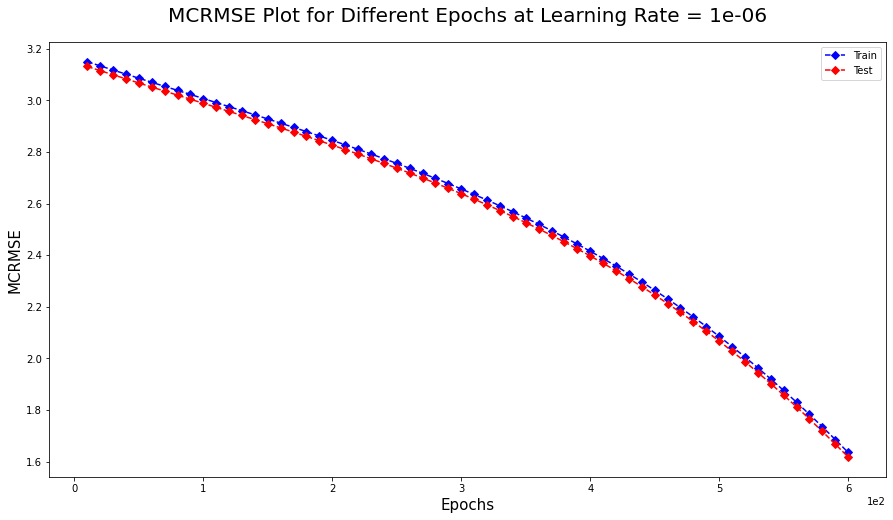

Initiating the network for learning rate: 1e-05
Train MCRMSE Info for Epochs = 100 is: (0.65808713, [0.6841272, 0.64606327, 0.591676, 0.65582436, 0.7002645, 0.67056745])
Train MCRMSE Info for Epochs = 200 is: (0.6530845, [0.6653926, 0.64380455, 0.58510226, 0.6553714, 0.6997686, 0.6690676])
Train MCRMSE Info for Epochs = 300 is: (0.6526252, [0.66495514, 0.64336073, 0.58463275, 0.65490425, 0.6992859, 0.6686123])
Train MCRMSE Info for Epochs = 400 is: (0.65213794, [0.66448736, 0.6428871, 0.5841353, 0.65440553, 0.69877976, 0.66813225])
Train MCRMSE Info for Epochs = 500 is: (0.6516292, [0.66399646, 0.6423913, 0.58361894, 0.65388703, 0.69825155, 0.6676301])
Train MCRMSE Info for Epochs = 600 is: (0.6511075, [0.66349304, 0.64188206, 0.5830915, 0.6533587, 0.6977072, 0.6671126])


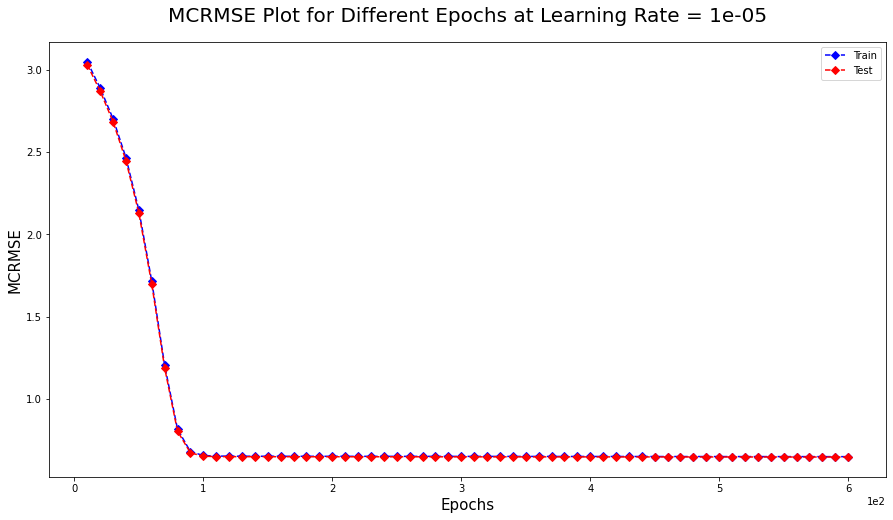

Initiating the network for learning rate: 0.0001
Train MCRMSE Info for Epochs = 100 is: (0.64546996, [0.6573463, 0.6364196, 0.57768714, 0.64794683, 0.69231147, 0.6611085])
Train MCRMSE Info for Epochs = 200 is: (0.6223581, [0.6339796, 0.61374027, 0.5547404, 0.624536, 0.6697224, 0.6374299])
Train MCRMSE Info for Epochs = 300 is: (0.57061845, [0.5861157, 0.56198025, 0.5068272, 0.56848556, 0.61753494, 0.5827672])
Train MCRMSE Info for Epochs = 400 is: (0.54421026, [0.56435996, 0.5350492, 0.4851282, 0.5414514, 0.5904475, 0.54882556])
Train MCRMSE Info for Epochs = 500 is: (0.5331688, [0.5546585, 0.5239874, 0.4748981, 0.5316842, 0.5797952, 0.5339894])
Train MCRMSE Info for Epochs = 600 is: (0.5252995, [0.5476187, 0.5157991, 0.4680419, 0.5244756, 0.57205695, 0.52380466])


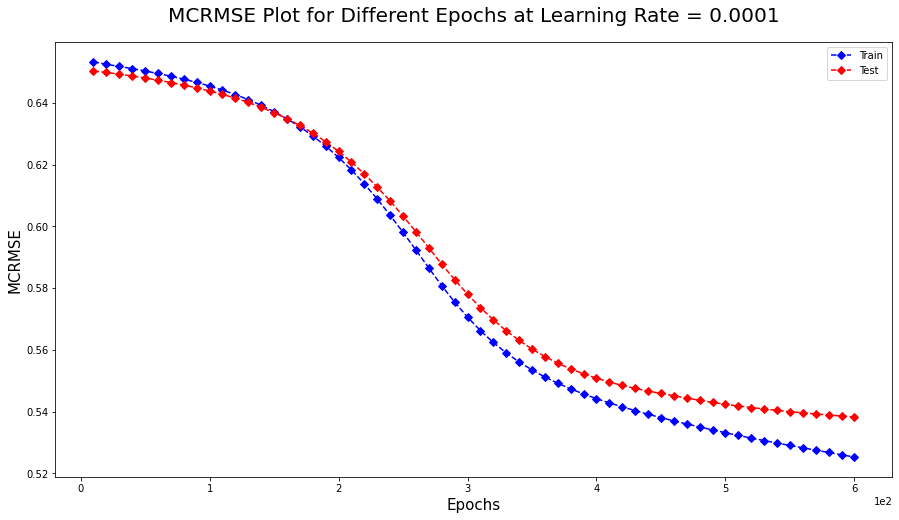

Initiating the network for learning rate: 0.001
Train MCRMSE Info for Epochs = 100 is: (0.5094778, [0.53456604, 0.4988045, 0.45444682, 0.50901526, 0.55487096, 0.5051634])
Train MCRMSE Info for Epochs = 200 is: (0.4625763, [0.48989376, 0.44683608, 0.41737476, 0.45853588, 0.50171185, 0.4611053])
Train MCRMSE Info for Epochs = 300 is: (0.39365044, [0.41878262, 0.37288573, 0.36175218, 0.37987906, 0.42617324, 0.4024299])
Train MCRMSE Info for Epochs = 400 is: (0.45978653, [0.479607, 0.44485536, 0.41756943, 0.45377567, 0.4881209, 0.47479087])
Train MCRMSE Info for Epochs = 500 is: (0.3855472, [0.40521222, 0.37157717, 0.35793293, 0.36848328, 0.41626868, 0.39380893])
Train MCRMSE Info for Epochs = 600 is: (0.4001094, [0.42314535, 0.3823259, 0.36828533, 0.3886585, 0.42370608, 0.4145353])


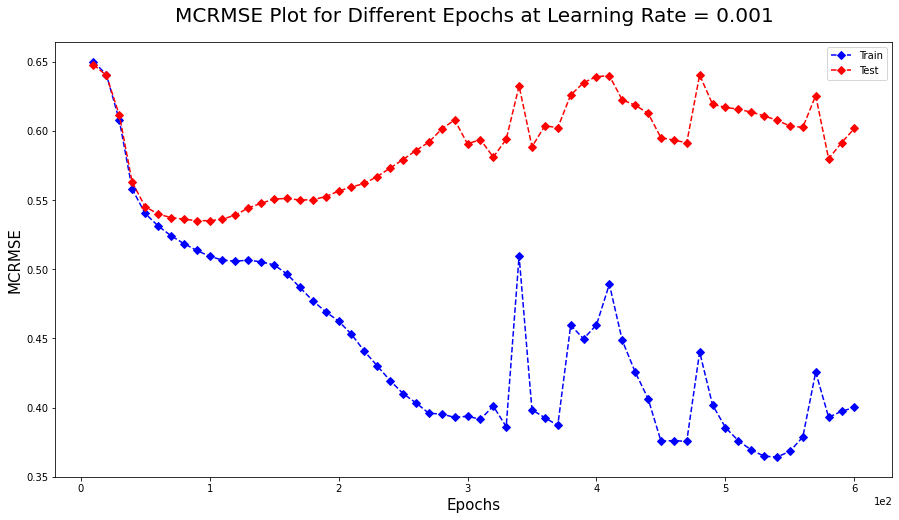

Initiating the network for learning rate: 0.01
Train MCRMSE Info for Epochs = 100 is: (0.4368213, [0.4581996, 0.41996825, 0.39609647, 0.42473093, 0.47091934, 0.4510132])
Train MCRMSE Info for Epochs = 200 is: (0.46614563, [0.47249964, 0.45174783, 0.43073994, 0.45280072, 0.5101749, 0.47891065])
Train MCRMSE Info for Epochs = 300 is: (0.41420326, [0.43995973, 0.40087134, 0.38215968, 0.405245, 0.42847016, 0.42851344])
Train MCRMSE Info for Epochs = 400 is: (0.4670852, [0.48298624, 0.45592842, 0.41147238, 0.4703201, 0.5120032, 0.46980092])
Train MCRMSE Info for Epochs = 500 is: (0.3322607, [0.32536677, 0.3450984, 0.31628475, 0.33862227, 0.35549933, 0.31269276])
Train MCRMSE Info for Epochs = 600 is: (0.33597812, [0.3074182, 0.36277723, 0.32760584, 0.3672217, 0.36868164, 0.28216398])


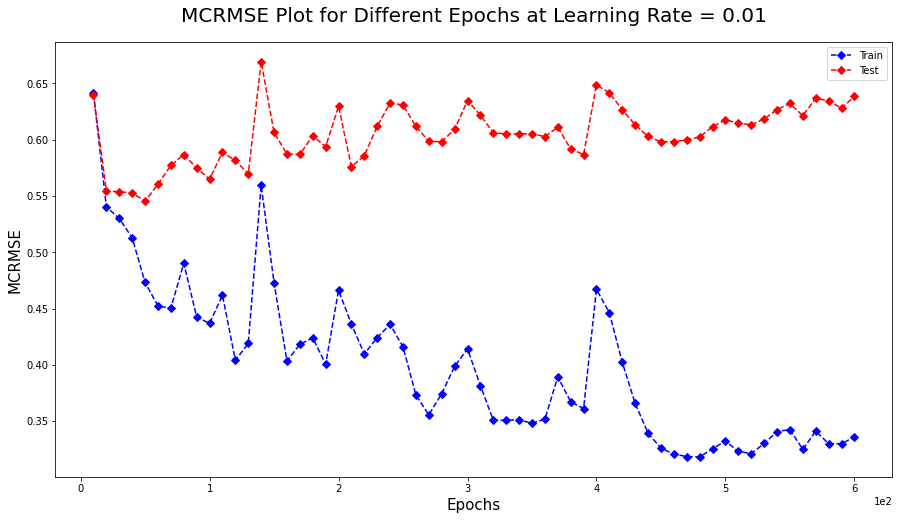

Observing MCRMSE with Change in Learning Rate
For Train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


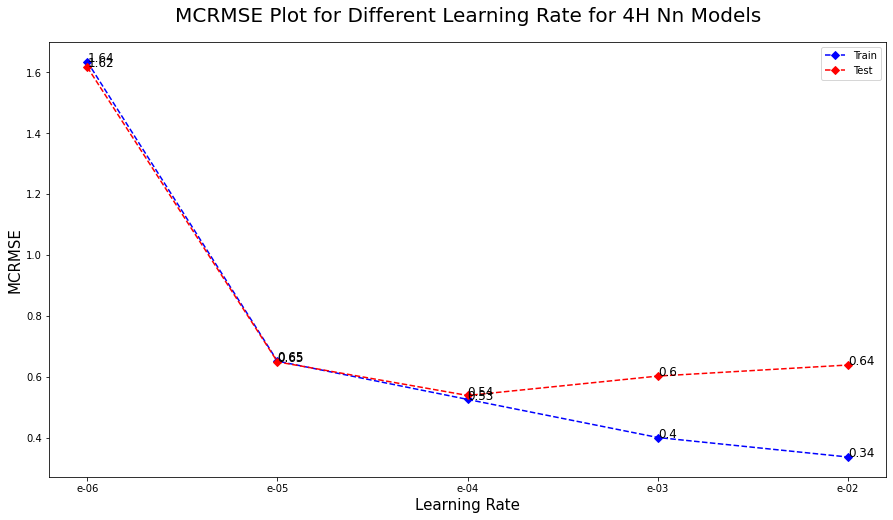

Generating Results Table
Generating Lowest Test MCRMSE Table


,Netowrk Type,Learning Rate,Epochs,Train MCRMSE,Test MCRMSE,cohesion Test RMSE,syntax Test RMSE,vocabulary Test RMSE,phraseology Test RMSE,grammar Test RMSE,conventions Test RMSE
0,4H NN,e-06,600,1.635173,1.617401,1.705752,1.504531,1.594113,1.798618,1.556392,1.544999
1,4H NN,e-05,600,0.651107,0.648697,0.632143,0.647279,0.563783,0.659916,0.699946,0.689113
2,4H NN,e-04,600,0.525299,0.538283,0.538548,0.531587,0.469407,0.546765,0.584903,0.558489
3,4H NN,e-03,96,0.511051,0.535106,0.539393,0.529320,0.462382,0.545830,0.584910,0.548799
4,4H NN,e-02,48,0.479589,0.544335,0.550195,0.540137,0.460779,0.560957,0.590765,0.563176


In [ ]:
##########--Predefined parameters--####################
# Update Before Running the block
epochs = 600
batch_size = 32
momentum = 0.9
learning_rate = np.logspace(-6,-2,num=5,base=10)
#######################################################
train_mcrmse_with_lr = []
test_mcrmse_with_lr = []
measure_rmse= []
lowest_test_mcrmse_list = []
lowest_test_mcrmse_train_list = []
lowest_mcrmse_epoch_list = []
lowest_test_measure_list = []
# Plot for Changing Learning Rate

for lrate in learning_rate:
  print("Initiating the network for learning rate:",lrate)
  #for plotting
  train_mcrmse = []
  test_mcrmse = []
  epochs_list = []
  lowest_test_mcrmse = 100
  lowest_mcrmse_measure = []
  lowest_mcrmse_epoch = 0

  #training block starts here--
  num_examples = trX.shape[0]
  num_examples
  num_batches = num_examples // batch_size

  #initiating the net class
  net = Net(768,100,6)
  criterion = nn.MSELoss()
  optimizer = optim.SGD(net.parameters(), lr=lrate, momentum=momentum)
  for e in range(1, epochs+1):
      loss = 0.
      for k in range(num_batches):
          start, end = k * batch_size, (k + 1) * batch_size
          loss += train(net,criterion,optimizer, trX[start:end], trY[start:end])
      train_correct = predict(net, trX, trY)
      test_correct = predict(net, teX, teY)
      
      if e%10==0 and e%100!=0 and e%epochs!=0:
        #print("Train MCRMSE Info for Epochs =",e,"is:",mcrmse(trY.detach().numpy(), train_correct.detach().numpy()))
        train_mcrmse.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        epochs_list.append(e)
      elif e%100==0 and e%epochs!=0:
        print("Train MCRMSE Info for Epochs =",e,"is:",mcrmse(trY.detach().numpy(), train_correct.detach().numpy()))
        train_mcrmse.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        epochs_list.append(e)
      elif e%epochs ==0:
        print("Train MCRMSE Info for Epochs =",e,"is:",mcrmse(trY.detach().numpy(), train_correct.detach().numpy()))
        train_mcrmse.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        #For learning rate curve
        train_mcrmse_with_lr.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse_with_lr.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        measure_rmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[1])
        epochs_list.append(e)
        #For saving minimum test mcrmse
      if lowest_test_mcrmse > mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0]:
        lowest_test_mcrmse = np.min([lowest_test_mcrmse,mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0]])
        lowest_test_mcrmse_train = mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0]
        lowest_mcrmse_epoch = e
        lowest_mcrmse_measure = mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[1]
      else: pass
  # plt.plot(train_mcrmse)
  # plt.xlabel('Epochs')
  # plt.ylabel('MCRMSE (On Train set)')
  # plt.show()

  # Saving lowest mcrmse parameters
  lowest_test_mcrmse_list.append(lowest_test_mcrmse)
  lowest_mcrmse_epoch_list.append(lowest_mcrmse_epoch)
  lowest_test_measure_list.append(lowest_mcrmse_measure)
  lowest_test_mcrmse_train_list.append(lowest_test_mcrmse_train)

  # Train vs Test Plot for different Epochs for a given Learning rate
  plt.figure(figsize=(15,8))
  plt.plot(epochs_list,train_mcrmse, '--', color = 'b', marker = 'D', label = "Train")
  plt.plot(epochs_list,test_mcrmse, '--', color = 'r', marker = 'D', label = "Test")
  plt.ylabel("MCRMSE", fontsize = 15)
  plt.xlabel("Epochs", fontsize = 15)
  plt.ticklabel_format(axis='x', style = 'sci', scilimits = (-6,-2))
  plt.title("MCRMSE Plot for Different Epochs at Learning Rate = {}".format(lrate), fontsize = 20, pad = 20)
  plt.legend()
  plt.show()
  # for index in range(len(epochs)):
  #   ax.text(learning_rate[index], train_mcrmse[index], round(train_mcrmse[index],2), size=12)


  # plt.plot(test_mcrmse)
  # plt.xlabel('Epochs')
  # plt.ylabel('MCRMSE (On test set)')
  # plt.show()


print("Observing MCRMSE with Change in Learning Rate")
learning_rate = ['e-06','e-05','e-04','e-03','e-02']
print("For Train")

fig5 = plt.figure(figsize=(15,8))
plt.plot(learning_rate,train_mcrmse_with_lr, '--', color = 'b', marker = 'D', label = "Train")
plt.plot(learning_rate,test_mcrmse_with_lr, '--', color = 'r', marker = 'D', label = "Test")
plt.ylabel("MCRMSE", fontsize = 15)
plt.xlabel("Learning Rate", fontsize = 15)
plt.title("MCRMSE Plot for Different Learning Rate for 4H Nn Models", fontsize = 20, pad = 20)
ax = fig5.add_subplot(111)
for index in range(len(learning_rate)):
  ax.text(learning_rate[index], train_mcrmse_with_lr[index], round(train_mcrmse_with_lr[index],2), size=12)
for index in range(len(learning_rate)):
  ax.text(learning_rate[index], test_mcrmse_with_lr[index], round(test_mcrmse_with_lr[index],2), size=12)
plt.legend()
plt.show()


# fig, ax = plt.subplots(figsize=(15,8))
# ax.plot(learning_rate,train_mcrmse_with_lr, '--', color = 'b', marker = 'D')
# ax.set_ylabel("MCRMSE", fontsize = 15)
# ax.set_xlabel("Learning Rate", fontsize = 15)
# ax.set_title("Train MCRMSE Plot for different Learning Rate", fontsize = 20, pad = 20)
# for index in range(len(learning_rate)):
#   ax.text(learning_rate[index], train_mcrmse_with_lr[index], round(train_mcrmse_with_lr[index],2), size=12)

# print("For Test")
# fig, ax = plt.subplots(figsize=(15,8))
# ax.plot(learning_rate,test_mcrmse_with_lr, '--', color = 'b', marker = 'D')
# ax.set_ylabel("MCRMSE", fontsize = 15)
# ax.set_xlabel("Learning Rate", fontsize = 15)
# ax.set_title("Test MCRMSE Plot for different Learning Rate", fontsize = 20, pad = 20)
# for index in range(len(learning_rate)):
#   ax.text(learning_rate[index], test_mcrmse_with_lr[index], round(test_mcrmse_with_lr[index],2), size=12)

print("Generating Results Table")
results_table5 = pd.DataFrame(
    {"Netowrk Type":"4H NN",
     "Learning Rate":learning_rate,
     "Train MCRMSE": train_mcrmse_with_lr,
     "Test MCRMSE": test_mcrmse_with_lr,
     "Measure Test RMSE": measure_rmse
     }
     )
results_table5[["cohesion Test RMSE", "syntax Test RMSE", "vocabulary Test RMSE", "phraseology Test RMSE", "grammar Test RMSE", "conventions Test RMSE"]] = pd.DataFrame(results_table5["Measure Test RMSE"].tolist(), index= results_table5.index)
results_table5.drop(["Measure Test RMSE"], axis=1)

print("Generating Lowest Test MCRMSE Table")
test_table5 = pd.DataFrame(
    {"Netowrk Type":"4H NN",
     "Learning Rate":learning_rate,
     "Epochs":lowest_mcrmse_epoch_list,
     "Train MCRMSE": lowest_test_mcrmse_train_list,
     "Test MCRMSE":   lowest_test_mcrmse_list,
     "Measure Test RMSE": lowest_test_measure_list
     }
     )
test_table5[["cohesion Test RMSE", "syntax Test RMSE", "vocabulary Test RMSE", "phraseology Test RMSE", "grammar Test RMSE", "conventions Test RMSE"]] = pd.DataFrame(test_table5["Measure Test RMSE"].tolist(), index= test_table5.index)
test_table5.drop(["Measure Test RMSE"], axis=1)

### 4 Hidden and 1 Dropout Layer NN Model

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.drop = nn.Dropout(p = 0.5)
        self.h2h2 = nn.Linear(hidden_size, hidden_size)
        self.h2h3 = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        
        #self.logsoftmax = nn.LogSoftmax()
        
    def forward(self, x):
        x = F.relu(self.i2h(x))
        x = F.relu(self.h2h(x))
        x = F.relu(self.drop(x))
        x = F.relu(self.h2h2(x))
        x = F.relu(self.h2h3(x))
        x = self.h2o(x)
        return x

Initiating the network for learning rate: 1e-06
Train MCRMSE Info for Epochs = 100 is: (3.0031092, [2.9857671, 2.9415624, 3.1508775, 2.9902124, 3.0678012, 2.8824348])
Train MCRMSE Info for Epochs = 200 is: (2.8227131, [2.7974024, 2.7537124, 2.9754112, 2.8109381, 2.8935657, 2.7052507])
Train MCRMSE Info for Epochs = 300 is: (2.6020906, [2.5704017, 2.5251555, 2.7592938, 2.590181, 2.682347, 2.4851649])
Train MCRMSE Info for Epochs = 400 is: (2.3053095, [2.269425, 2.2189445, 2.4648032, 2.2934148, 2.3950126, 2.190257])
Train MCRMSE Info for Epochs = 500 is: (1.8871504, [1.8491628, 1.7925458, 2.040373, 1.8762615, 1.9853313, 1.7792281])
Train MCRMSE Info for Epochs = 600 is: (1.345295, [1.3104419, 1.2526779, 1.4688635, 1.336868, 1.4439876, 1.2589298])


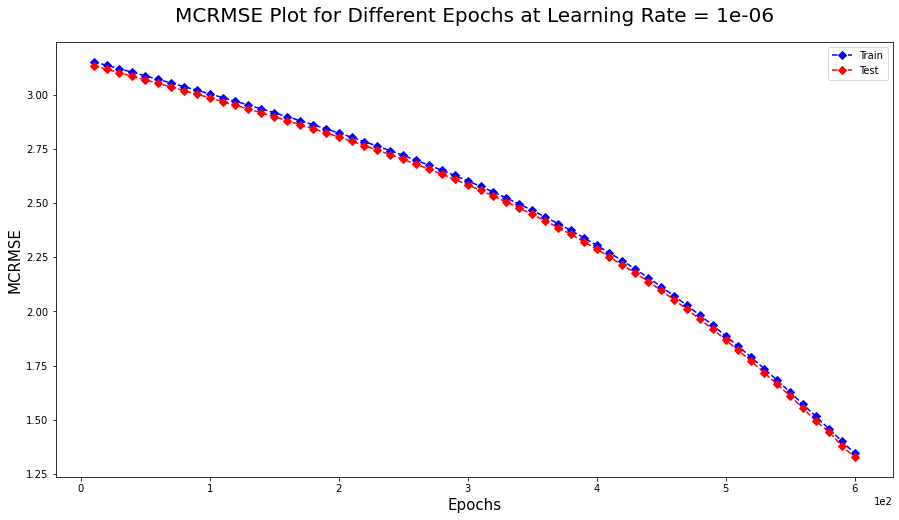

Initiating the network for learning rate: 1e-05
Train MCRMSE Info for Epochs = 100 is: (0.6683906, [0.68150145, 0.6582878, 0.60351646, 0.67032295, 0.71310914, 0.68360585])
Train MCRMSE Info for Epochs = 200 is: (0.6650333, [0.6774989, 0.65470845, 0.5991679, 0.66610926, 0.7108591, 0.68185604])
Train MCRMSE Info for Epochs = 300 is: (0.6601612, [0.671009, 0.65151554, 0.5931191, 0.6628158, 0.7068273, 0.67568016])
Train MCRMSE Info for Epochs = 400 is: (0.65690273, [0.6716968, 0.6469768, 0.58845913, 0.659021, 0.70226014, 0.67300224])
Train MCRMSE Info for Epochs = 500 is: (0.658004, [0.67163277, 0.6479165, 0.59129596, 0.65983474, 0.7034986, 0.6738451])
Train MCRMSE Info for Epochs = 600 is: (0.6554469, [0.66890293, 0.64517397, 0.587951, 0.656838, 0.7022573, 0.67155814])


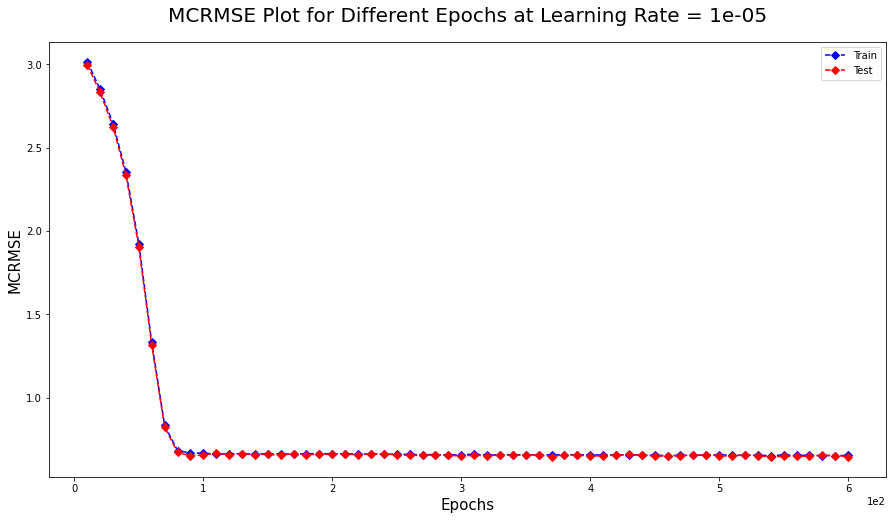

Initiating the network for learning rate: 0.0001
Train MCRMSE Info for Epochs = 100 is: (0.6491645, [0.6617493, 0.6397398, 0.5818279, 0.6516152, 0.6952587, 0.6647961])
Train MCRMSE Info for Epochs = 200 is: (0.63623756, [0.6498483, 0.62743837, 0.56796616, 0.63769364, 0.6832563, 0.6512224])
Train MCRMSE Info for Epochs = 300 is: (0.5965802, [0.61296606, 0.58682626, 0.5310148, 0.5951299, 0.6443672, 0.6091769])
Train MCRMSE Info for Epochs = 400 is: (0.5627674, [0.5815989, 0.55467904, 0.500837, 0.5608244, 0.6088793, 0.5697856])
Train MCRMSE Info for Epochs = 500 is: (0.54887825, [0.5710891, 0.5406529, 0.48815534, 0.5463181, 0.5953786, 0.5516755])
Train MCRMSE Info for Epochs = 600 is: (0.5373114, [0.5604576, 0.52756155, 0.47751904, 0.53636855, 0.5833548, 0.538607])


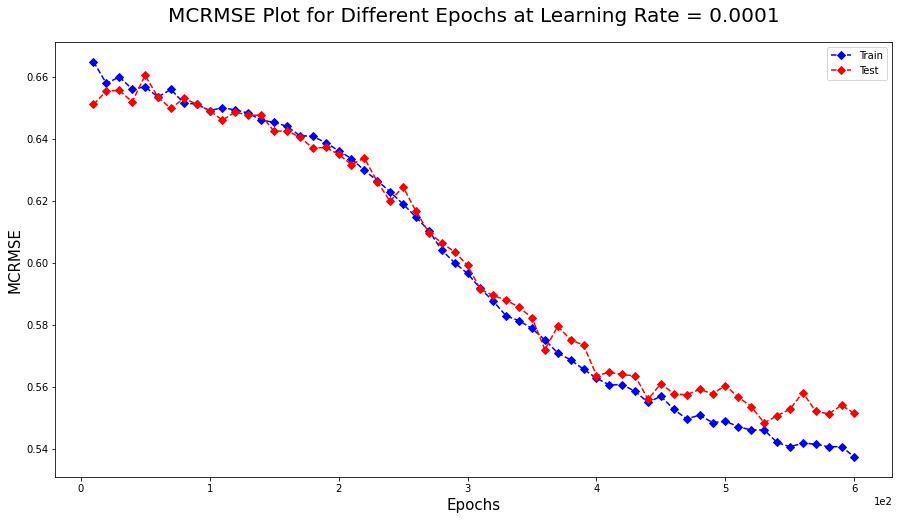

Initiating the network for learning rate: 0.001
Train MCRMSE Info for Epochs = 100 is: (0.52831155, [0.552601, 0.5180629, 0.469286, 0.52842855, 0.5711807, 0.53031015])
Train MCRMSE Info for Epochs = 200 is: (0.501601, [0.528841, 0.4874865, 0.44653434, 0.50056344, 0.54516226, 0.5010185])
Train MCRMSE Info for Epochs = 300 is: (0.44975433, [0.47817358, 0.43034205, 0.40594134, 0.44442737, 0.48617423, 0.45346725])
Train MCRMSE Info for Epochs = 400 is: (0.47533274, [0.49778807, 0.45838705, 0.43002066, 0.47014505, 0.5108814, 0.4847742])
Train MCRMSE Info for Epochs = 500 is: (0.45917168, [0.47862995, 0.4463342, 0.4198265, 0.44989178, 0.49406177, 0.466286])
Train MCRMSE Info for Epochs = 600 is: (0.42867222, [0.45128098, 0.4109035, 0.39160377, 0.41916293, 0.45729044, 0.44179186])


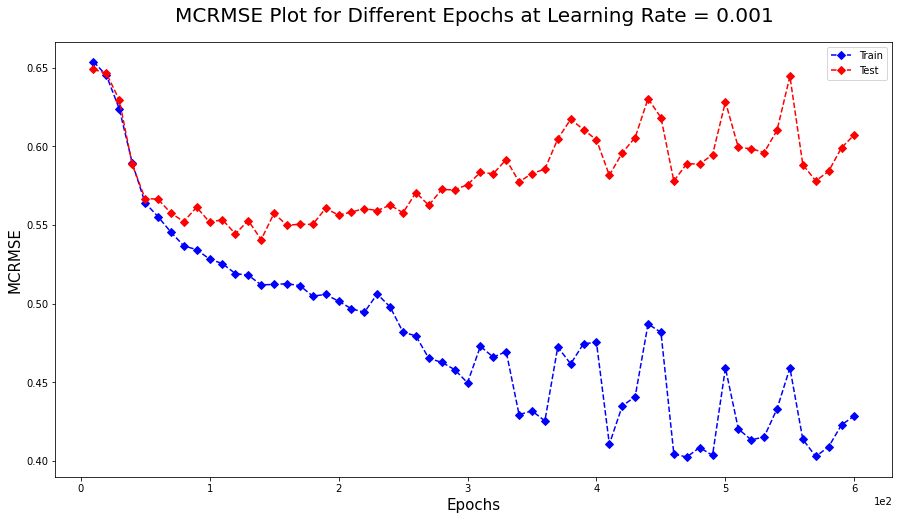

Initiating the network for learning rate: 0.01
Train MCRMSE Info for Epochs = 100 is: (0.5273746, [0.5533062, 0.5150692, 0.47353792, 0.52857965, 0.5615884, 0.5321663])
Train MCRMSE Info for Epochs = 200 is: (0.44349918, [0.46785575, 0.42952773, 0.40703246, 0.4393773, 0.46799982, 0.44920197])
Train MCRMSE Info for Epochs = 300 is: (0.38043764, [0.40311295, 0.36368093, 0.35153368, 0.36719435, 0.4045907, 0.39251348])
Train MCRMSE Info for Epochs = 400 is: (0.38394213, [0.4080738, 0.36638647, 0.35517415, 0.36938828, 0.40186372, 0.40276638])
Train MCRMSE Info for Epochs = 500 is: (0.37289786, [0.38778242, 0.3601257, 0.34450662, 0.36138663, 0.3964237, 0.38716203])
Train MCRMSE Info for Epochs = 600 is: (0.44514894, [0.4717552, 0.43024653, 0.4008613, 0.43937442, 0.45916095, 0.46949524])


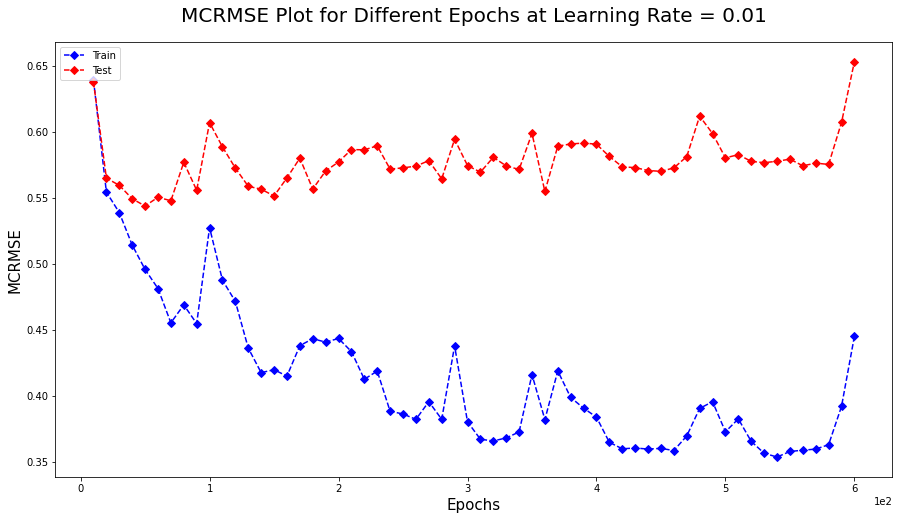

Observing MCRMSE with Change in Learning Rate
For Train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


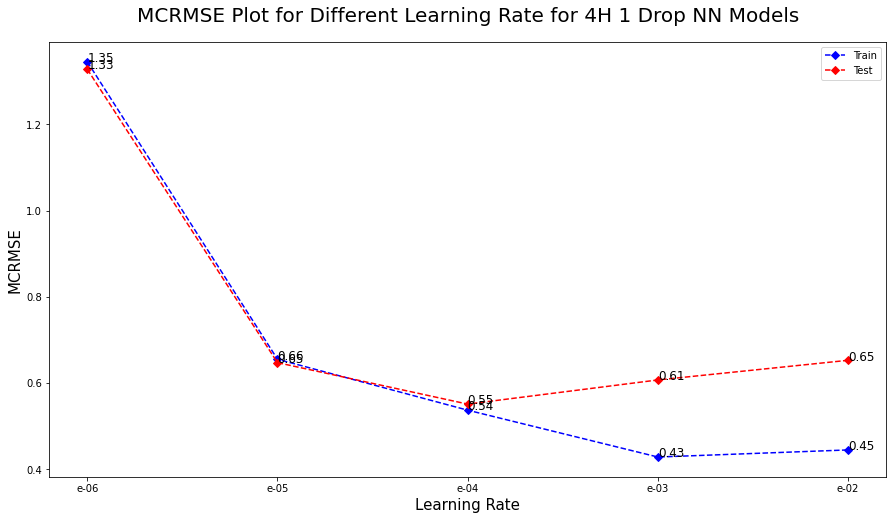

Generating Results Table
Generating Lowest Test MCRMSE Table


,Netowrk Type,Learning Rate,Epochs,Train MCRMSE,Test MCRMSE,cohesion Test RMSE,syntax Test RMSE,vocabulary Test RMSE,phraseology Test RMSE,grammar Test RMSE,conventions Test RMSE
0,4H 1 Drop NN,e-06,600,1.345295,1.327890,1.292132,1.235288,1.421515,1.330195,1.453168,1.235043
1,4H 1 Drop NN,e-05,468,0.655963,0.642571,0.627845,0.638207,0.563624,0.648550,0.695810,0.681387
2,4H 1 Drop NN,e-04,592,0.538699,0.543293,0.548481,0.536241,0.472115,0.549452,0.589260,0.564207
3,4H 1 Drop NN,e-03,131,0.515283,0.538220,0.540183,0.531807,0.464064,0.553095,0.586518,0.553651
4,4H 1 Drop NN,e-02,36,0.519832,0.542454,0.551769,0.534003,0.474750,0.554464,0.584605,0.555135


In [ ]:
##########--Predefined parameters--####################
# Update Before Running the block
epochs = 600
batch_size = 32
momentum = 0.9
learning_rate = np.logspace(-6,-2,num=5,base=10)
#######################################################
train_mcrmse_with_lr = []
test_mcrmse_with_lr = []
measure_rmse= []
lowest_test_mcrmse_list = []
lowest_test_mcrmse_train_list = []
lowest_mcrmse_epoch_list = []
lowest_test_measure_list = []
# Plot for Changing Learning Rate

for lrate in learning_rate:
  print("Initiating the network for learning rate:",lrate)
  #for plotting
  train_mcrmse = []
  test_mcrmse = []
  epochs_list = []
  lowest_test_mcrmse = 100
  lowest_mcrmse_measure = []
  lowest_mcrmse_epoch = 0

  #training block starts here--
  num_examples = trX.shape[0]
  num_examples
  num_batches = num_examples // batch_size

  #initiating the net class
  net = Net(768,100,6)
  criterion = nn.MSELoss()
  optimizer = optim.SGD(net.parameters(), lr=lrate, momentum=momentum)
  for e in range(1, epochs+1):
      loss = 0.
      for k in range(num_batches):
          start, end = k * batch_size, (k + 1) * batch_size
          loss += train(net,criterion,optimizer, trX[start:end], trY[start:end])
      train_correct = predict(net, trX, trY)
      test_correct = predict(net, teX, teY)
      
      if e%10==0 and e%100!=0 and e%epochs!=0:
        #print("Train MCRMSE Info for Epochs =",e,"is:",mcrmse(trY.detach().numpy(), train_correct.detach().numpy()))
        train_mcrmse.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        epochs_list.append(e)
      elif e%100==0 and e%epochs!=0:
        print("Train MCRMSE Info for Epochs =",e,"is:",mcrmse(trY.detach().numpy(), train_correct.detach().numpy()))
        train_mcrmse.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        epochs_list.append(e)
      elif e%epochs ==0:
        print("Train MCRMSE Info for Epochs =",e,"is:",mcrmse(trY.detach().numpy(), train_correct.detach().numpy()))
        train_mcrmse.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        #For learning rate curve
        train_mcrmse_with_lr.append(mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
        test_mcrmse_with_lr.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])
        measure_rmse.append(mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[1])
        epochs_list.append(e)
        #For saving minimum test mcrmse
      if lowest_test_mcrmse > mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0]:
        lowest_test_mcrmse = np.min([lowest_test_mcrmse,mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0]])
        lowest_test_mcrmse_train = mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0]
        lowest_mcrmse_epoch = e
        lowest_mcrmse_measure = mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[1]
      else: pass
  # plt.plot(train_mcrmse)
  # plt.xlabel('Epochs')
  # plt.ylabel('MCRMSE (On Train set)')
  # plt.show()

  # Saving lowest mcrmse parameters
  lowest_test_mcrmse_list.append(lowest_test_mcrmse)
  lowest_mcrmse_epoch_list.append(lowest_mcrmse_epoch)
  lowest_test_measure_list.append(lowest_mcrmse_measure)
  lowest_test_mcrmse_train_list.append(lowest_test_mcrmse_train)

  # Train vs Test Plot for different Epochs for a given Learning rate
  plt.figure(figsize=(15,8))
  plt.plot(epochs_list,train_mcrmse, '--', color = 'b', marker = 'D', label = "Train")
  plt.plot(epochs_list,test_mcrmse, '--', color = 'r', marker = 'D', label = "Test")
  plt.ylabel("MCRMSE", fontsize = 15)
  plt.xlabel("Epochs", fontsize = 15)
  plt.ticklabel_format(axis='x', style = 'sci', scilimits = (-6,-2))
  plt.title("MCRMSE Plot for Different Epochs at Learning Rate = {}".format(lrate), fontsize = 20, pad = 20)
  plt.legend()
  plt.show()
  # for index in range(len(epochs)):
  #   ax.text(learning_rate[index], train_mcrmse[index], round(train_mcrmse[index],2), size=12)


  # plt.plot(test_mcrmse)
  # plt.xlabel('Epochs')
  # plt.ylabel('MCRMSE (On test set)')
  # plt.show()


print("Observing MCRMSE with Change in Learning Rate")
learning_rate = ['e-06','e-05','e-04','e-03','e-02']
print("For Train")

fig6 = plt.figure(figsize=(15,8))
plt.plot(learning_rate,train_mcrmse_with_lr, '--', color = 'b', marker = 'D', label = "Train")
plt.plot(learning_rate,test_mcrmse_with_lr, '--', color = 'r', marker = 'D', label = "Test")
plt.ylabel("MCRMSE", fontsize = 15)
plt.xlabel("Learning Rate", fontsize = 15)
plt.title("MCRMSE Plot for Different Learning Rate for 4H 1 Drop NN Models", fontsize = 20, pad = 20)
ax = fig6.add_subplot(111)
for index in range(len(learning_rate)):
  ax.text(learning_rate[index], train_mcrmse_with_lr[index], round(train_mcrmse_with_lr[index],2), size=12)
for index in range(len(learning_rate)):
  ax.text(learning_rate[index], test_mcrmse_with_lr[index], round(test_mcrmse_with_lr[index],2), size=12)
plt.legend()
plt.show()


# fig, ax = plt.subplots(figsize=(15,8))
# ax.plot(learning_rate,train_mcrmse_with_lr, '--', color = 'b', marker = 'D')
# ax.set_ylabel("MCRMSE", fontsize = 15)
# ax.set_xlabel("Learning Rate", fontsize = 15)
# ax.set_title("Train MCRMSE Plot for different Learning Rate", fontsize = 20, pad = 20)
# for index in range(len(learning_rate)):
#   ax.text(learning_rate[index], train_mcrmse_with_lr[index], round(train_mcrmse_with_lr[index],2), size=12)

# print("For Test")
# fig, ax = plt.subplots(figsize=(15,8))
# ax.plot(learning_rate,test_mcrmse_with_lr, '--', color = 'b', marker = 'D')
# ax.set_ylabel("MCRMSE", fontsize = 15)
# ax.set_xlabel("Learning Rate", fontsize = 15)
# ax.set_title("Test MCRMSE Plot for different Learning Rate", fontsize = 20, pad = 20)
# for index in range(len(learning_rate)):
#   ax.text(learning_rate[index], test_mcrmse_with_lr[index], round(test_mcrmse_with_lr[index],2), size=12)

print("Generating Results Table")
results_table6 = pd.DataFrame(
    {"Netowrk Type":"4H 1 Drop NN",
     "Learning Rate":learning_rate,
     "Train MCRMSE": train_mcrmse_with_lr,
     "Test MCRMSE": test_mcrmse_with_lr,
     "Measure Test RMSE": measure_rmse
     }
     )
results_table6[["cohesion Test RMSE", "syntax Test RMSE", "vocabulary Test RMSE", "phraseology Test RMSE", "grammar Test RMSE", "conventions Test RMSE"]] = pd.DataFrame(results_table6["Measure Test RMSE"].tolist(), index= results_table6.index)
results_table6.drop(["Measure Test RMSE"], axis=1)

print("Generating Lowest Test MCRMSE Table")
test_table6 = pd.DataFrame(
    {"Netowrk Type":"4H 1 Drop NN",
     "Learning Rate":learning_rate,
     "Epochs":lowest_mcrmse_epoch_list,
     "Train MCRMSE": lowest_test_mcrmse_train_list,
     "Test MCRMSE":   lowest_test_mcrmse_list,
     "Measure Test RMSE": lowest_test_measure_list
     }
     )
test_table6[["cohesion Test RMSE", "syntax Test RMSE", "vocabulary Test RMSE", "phraseology Test RMSE", "grammar Test RMSE", "conventions Test RMSE"]] = pd.DataFrame(test_table6["Measure Test RMSE"].tolist(), index= test_table6.index)
test_table6.drop(["Measure Test RMSE"], axis=1)

In [ ]:
results_table6

#### Scoring Using Best Model

In [ ]:
### Forward function
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.drop = nn.Dropout(p = 0.5)
        self.h2h2 = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        
        #self.logsoftmax = nn.LogSoftmax()
        
    def forward(self, x):
        x = F.relu(self.i2h(x))
        x = F.relu(self.h2h(x))
        x = F.relu(self.drop(x))
        x = F.relu(self.h2h2(x))
        x = self.h2o(x)
        return x

In [ ]:
epochs = 226# enter best epoch value
batch_size = 32
momentum = 0.9
learning_rate = 0.001# enter best lr value


#training block starts here--
num_examples = trX.shape[0]
num_examples
num_batches = num_examples // batch_size

#initiating the net class
net = Net(768,100,6)
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
for e in range(1, epochs+1):
      loss = 0.
      for k in range(num_batches):
          start, end = k * batch_size, (k + 1) * batch_size
          loss += train(net,criterion,optimizer, trX[start:end], trY[start:end])

train_correct = predict(net, trX, trY)
test_correct = predict(net, teX, teY)

print("Train MCRMSE:",mcrmse(trY.detach().numpy(), train_correct.detach().numpy())[0])
print("Test MCRMSE:",mcrmse(teY.detach().numpy(), test_correct.detach().numpy())[0])

Train MCRMSE: 0.49245632
Test MCRMSE: 0.54970783


In [ ]:
final_predictions = predict(net, X_full, y_full)
print("Overall MCRMSE:",mcrmse(y_full.detach().numpy(), final_predictions.detach().numpy())[0]) # This observation is biased because of 80% of data in training
final_predictions = final_predictions.detach().numpy()
final_predictions.shape

Overall MCRMSE: 0.49738756


(3911, 6)

In [ ]:
essay_data = embeddings[['text_id', 'cohesion','syntax','vocabulary','phraseology','grammar','conventions']]
print("Data Shape:",essay_data.shape)
essay_data.head(5)

Data Shape: (3911, 7)


,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,2.5,3.0,3.0,3.0,2.5,2.5


In [ ]:
task_preds = ["cohesion_pred", "syntax_pred", "vocabulary_pred", "phraseology_pred", "grammar_pred", "conventions_pred"]
pred_df = pd.DataFrame(final_predictions, columns=task_preds)
pred_df.head(5)

,cohesion_pred,syntax_pred,vocabulary_pred,phraseology_pred,grammar_pred,conventions_pred
0,2.908636,2.817527,3.038192,2.896601,2.810318,2.854688
1,2.756859,2.660746,2.892979,2.735506,2.644831,2.686680
2,2.928391,2.835896,3.051665,2.916801,2.828712,2.870555
3,3.789284,3.715129,3.874284,3.804431,3.744031,3.798734
4,2.653883,2.546746,2.796125,2.632994,2.528510,2.570145


In [ ]:
results = pd.concat([essay_data, pred_df], axis=1)
results.head(5)

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_pred,syntax_pred,vocabulary_pred,phraseology_pred,grammar_pred,conventions_pred
0,0016926B079C,3.5,3.5,3.0,3.0,4.0,3.0,2.908636,2.817527,3.038192,2.896601,2.810318,2.854688
1,0022683E9EA5,2.5,2.5,3.0,2.0,2.0,2.5,2.756859,2.660746,2.892979,2.735506,2.644831,2.686680
2,00299B378633,3.0,3.5,3.0,3.0,3.0,2.5,2.928391,2.835896,3.051665,2.916801,2.828712,2.870555
3,003885A45F42,4.5,4.5,4.5,4.5,4.0,5.0,3.789284,3.715129,3.874284,3.804431,3.744031,3.798734
4,0049B1DF5CCC,2.5,3.0,3.0,3.0,2.5,2.5,2.653883,2.546746,2.796125,2.632994,2.528510,2.570145


In [ ]:
results.to_csv(data_path+'3h1d_nn_predictions.csv')